In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import eatpy
import copy
import yaml
from scipy.stats import qmc

In [2]:
from define_parameter_range import parameter_range,parameter_path

name_para = [row[0] for row in parameter_range]
l_bounds = [row[1] for row in parameter_range]
u_bounds = [row[2] for row in parameter_range]
n_decimals = [row[3] for row in parameter_range]

In [41]:
def generate_fabm_yaml_LHS(N):
    D = len(name_para)     # parameter size
    sampler = qmc.LatinHypercube(d=D)
    sample = sampler.random(n=N)
    sample_scaled = qmc.scale(sample, l_bounds, u_bounds)
    sample_rounded = np.zeros_like(sample_scaled)
    for i in range(np.shape(sample_scaled)[1]):
        sample_rounded[:,i] = np.round(sample_scaled[:,i],decimals=n_decimals[i])
        
    with eatpy.models.gotm.YAMLEnsemble("gotm.yaml", N) as gotm, eatpy.models.gotm.YAMLEnsemble("fabm.yaml", N) as fabm:
    # Commenting below will generate identical gotm_####.yaml files (do this if you want identical physics).
    #    gotm["surface/u10/scale_factor"] = np.random.lognormal(sigma=0.1, size=N)
    #    gotm["surface/v10/scale_factor"] = np.random.lognormal(sigma=0.1, size=N)
        # Link each gotm_####.yaml to the corresponding fabm_####.yaml
        gotm["fabm/yaml_file"] = fabm.file_paths
        # Set the MEMG model parameters
        for i in range(len(name_para)):
            fabm[parameter_path+name_para[i]] = sample_rounded[:,i]

    # Save the parameter values
    header = ','.join(name_para)
    np.savetxt("parameter-values-" + str(N) + ".csv",
               sample_rounded,
               delimiter=",",
               header=header,
               comments='')

def fit_fun(obs,model,metric):
    if metric == 'corr': #Normalized pearson's correlation coefficient (range: 0 to 1)
        return (xr.corr(obs,model).values + 1)/2
    if metric == 'mapd': #ONE minus Bounded Mean Absolute Proportional Difference (range: 0 to 1), where MAPD is bounded to 1.
        return 1 - min(1,abs(((model - obs)/obs).mean().values))

### Initial population generation

In [161]:
maxgen = 100 # maximum number of generations/iterations allowed
N = 10 # population/ensemble size
tarfit = 0.9 # target fitness score
prob_mutation = 0.1 # probability of mutation for each parameter offspring during crossover
N_random = 1 # the number of individual(s) produced randomly
generate_fabm_yaml_LHS(N) # generate the initial population using Latin Hypercubic Sampling

# list of file names for the population
files = ['result_%04i.nc' % (i + 1) for i in range(N)]
files = np.array(files)

idx_time = range(100,300,10) # every 10 days after 100 days
idx_dep = range(1,101,10) # very 10 m from 1 m
tarvars = ["1p1z_no3"]#,"1p1z_chl"] # target variables
tarmets = ['mapd'] #,'corr'] # target metrics

arr_fit = np.zeros((N,maxgen)) # array containing fitness

# run the control simulation
!eat-gotm
# load the control simulation results
ds_tar = xr.open_dataset('result.nc')

# create a symbolic link of fabm.yaml as fabm_next.yaml used for generating yaml files for the subsequent generations
!ln -s fabm.yaml fabm_next.yaml

INFO:root:Using template fabm.yaml...
INFO:root:  instances/1p1z/parameters/attCHL: 0.02486
INFO:root:  instances/1p1z/parameters/I_thNH4: 0.0095
INFO:root:  instances/1p1z/parameters/D_p5NH4: 0.1
INFO:root:  instances/1p1z/parameters/NitriR: 0.05
INFO:root:  instances/1p1z/parameters/K_NO3: 2.0
INFO:root:  instances/1p1z/parameters/K_NH4: 2.0
INFO:root:  instances/1p1z/parameters/Vp0: 0.69
INFO:root:  instances/1p1z/parameters/K_Phy: 0.5
INFO:root:  instances/1p1z/parameters/PhyIS: 0.025
INFO:root:  instances/1p1z/parameters/PhyMR: 0.072
INFO:root:  instances/1p1z/parameters/Chl2C_m: 0.0535
INFO:root:  instances/1p1z/parameters/ZooAE_N: 0.75
INFO:root:  instances/1p1z/parameters/ZooBM: 0.1
INFO:root:  instances/1p1z/parameters/ZooER: 0.1
INFO:root:  instances/1p1z/parameters/ZooGR: 0.75
INFO:root:  instances/1p1z/parameters/ZooMR: 0.025
INFO:root:  instances/1p1z/parameters/LDeRRN: 0.01
INFO:root:  instances/1p1z/parameters/SDeRRN: 0.03
INFO:root:  instances/1p1z/parameters/CoagR: 0.0

 model(no filter program present)
    initialize_gotm
 ------------------------------------------------------------------------
        Reading configuration from: gotm.yaml
        configuring modules ....
    init_airsea_yaml
        done
    init_observations_yaml
    init_stokes_drift_yaml
        done
    init_turbulence_yaml
        done.
    init_gotm_fabm_yaml
        Reading configuration from:
            fabm.yaml
        done.
    init_meanflow_yaml
        done
    init_eqstate_yaml
        done.
 Initializing light...
    model type: memg/bio_fennel/light
    initialization succeeded.
 Initializing 1p1z...
    model type: memg/bio_fennel/1p1z
    initialization succeeded.
 SKIPPING model instance 2p2z because it has use=false set.
 SKIPPING model instance 2p2z_sink because it has use=false set.
 SKIPPING model instance oxygen because it has use=false set.
        GOTM Simulation
        Using          110  layers to resolve a depth of   110.00000000000000     
        The

### fitness calculation
To do:

- consider rounding for disregarding subtle variations for correlations (overfitting)

In [ ]:
if N_random < N:
    for igen in range(maxgen): # loop over the generation/iteration
    
        # Ensemble simulation
        # Use Python's string formatting to substitute N into the shell command
        # Use double curly braces to escape them for the parallel command
        command = f"seq -f '%04g' 1 {N} | parallel -j 8 'eat-gotm gotm_{{}}.yaml --output_id _{{}}'"
        # Run the shell command
        !{command}
    
        # Fitness calculation
        for i in range(N): # loop over the population
            ds_ind = xr.open_dataset(files[i])
            for j in range(len(tarvars)): # loop over target variables
                data_tar = ds_tar[tarvars[j]].isel(time=idx_time,z=idx_dep) # data from the target
                data_ind = ds_ind[tarvars[j]].isel(time=idx_time,z=idx_dep) # data from an ensemble member
                for k in range(len(tarmets)): # loop over target metrics
                    arr_fit[i,igen] += fit_fun(data_tar,data_ind,tarmets[k])
        # mean fitness score
        arr_fit[:,igen] = arr_fit[:,igen] / (len(tarmets)+len(tarvars))          
        # np.argsort is in ascending order, so use np.flip to change it to descending order
        sorted_idx = np.flip(np.argsort(arr_fit[:,igen])) # indices of the fitness array in the descending order (best fitness first, worst last)
        # assign probabilities for individuals based on their fitness.
        prob4crossover = arr_fit[sorted_idx[:-1],igen] / np.sum(arr_fit[sorted_idx[:-1],igen])
        
        # elitism (keep the best individul for the next generation)
        best_file = files[sorted_idx][0]
        dest_file = "result_best.nc"
        !cp {best_file} {dest_file}
        
        # discard the worst individual for the next generation
        files_minus = files[sorted_idx[:-1]]
    
        # check whether to continue to the next generation
        if tarfit and arr_fit.max() > tarfit: #satisfy the target?
            print('The fitness satisfies the target')
            break
        #elif median(arr_fit[:,igen]
            #print('The fitness is saturated')
            #break
        # Subsequent population generation
        else:
            # crossover
            offspring = np.zeros((N,len(name_para))) # initialize 2d array of the offspring values
            for j in range(N): # generate N individuals by crossover (the remaining two are generated via elitism and random)
                # select a father and a mother which cannot be identical with a defined probability
                # it is possible to have the same father-mother pair for some dividiuals but the likelihood of producing identical offspring is low.
                father,mother = np.random.choice(files_minus,size=2,replace=False,p=prob4crossover)
                father_yaml = 'fabm_'+father[-7:-3]+'.yaml'
                mother_yaml = 'fabm_'+mother[-7:-3]+'.yaml'
                # Open the YAML file and load its contents
                with open(father_yaml, 'r') as file:
                    father_par = yaml.safe_load(file)
                with open(mother_yaml, 'r') as file:
                    mother_par = yaml.safe_load(file)
                for i in range(len(name_para)):
                    father_val = copy.deepcopy(father_par)
                    mother_val = copy.deepcopy(mother_par)
                    for part in (parameter_path+name_para[i]).split('/'):
                        father_val = father_val[part]
                        mother_val = mother_val[part]
                    # set the value of either parent
                    offspring[j,i] = np.random.choice([father_val,mother_val])
                    # mutation with a specified probability: randomly select a value between the two parents
                    if np.random.uniform(0,1) < prob_mutation:
                        offspring[j,i] = round(np.random.uniform(min(father_val,mother_val),max(father_val,mother_val)),n_decimals[i])
            with eatpy.models.gotm.YAMLEnsemble("fabm_next.yaml", N) as fabm:
                for i in range(len(name_para)):
                    fabm[parameter_path+name_para[i]] = offspring[:,i]
            
            # elitism: keep the best individual for the next generation
            source_yaml = 'fabm_'+best_file[-7:-3]+'.yaml'
            dest_yaml = 'fabm_next_'+files[-1][-7:-3]+'.yaml' # the last file is reserved for elitism
            !cp {source_yaml} {dest_yaml}
            
            # random: for exploration of parameter space and prevention from local minima, generate a totally random individual
            with eatpy.models.gotm.YAMLEnsemble("fabm_next.yaml", N_random) as fabm: # 1 is hard coded to generate only one ensemble 0001 
                for i in range(len(name_para)):
                    # assign the value of the parameters for 0001 to N_random files.
                    fabm[parameter_path+name_para[i]] = [float(np.random.choice(np.arange(l_bounds[i],u_bounds[i]+10**-n_decimals[i],10**-n_decimals[i]))) for _ in range(N_random)] #[] is essential even though the array size is 1 here.
            
            # replace the next generation population by the current generation population 
            for i in range(N):
                source_yaml = 'fabm_next_'+files[i][-7:-3]+'.yaml'
                dest_yaml = 'fabm_'+files[i][-7:-3]+'.yaml'
                !mv {source_yaml} {dest_yaml}
else:
    print('The random individual size (N_random) cannot be equal to the population size (N). Otherwise, no elitism.')

Academic tradition requires you to cite works you base your article on.
If you use programs that use GNU Parallel to process data for an article in a
scientific publication, please cite:

  Tange, O. (2025, April 22). GNU Parallel 20250422 ('Tariffs').
  Zenodo. https://doi.org/10.5281/zenodo.15265748

This helps funding further development; AND IT WON'T COST YOU A CENT.
If you pay 10000 EUR you should feel free to use GNU Parallel without citing.

More about funding GNU Parallel and the citation notice:
https://www.gnu.org/software/parallel/parallel_design.html#citation-notice

To silence this citation notice: run 'parallel --citation' once.

Come on: You have run parallel 580 times. Isn't it about time 
you run 'parallel --citation' once to silence the citation notice?

 Initializing light...
    model type: memg/bio_fennel/light
    initialization succeeded.
 Initializing 1p1z...
    model type: memg/bio_fennel/1p1z
    initialization succeeded.
 SKIPPING model instance 2p2z because

INFO:root:Using template fabm_next.yaml...
INFO:root:  instances/1p1z/parameters/attCHL: 0.02486
INFO:root:  instances/1p1z/parameters/I_thNH4: 0.0095
INFO:root:  instances/1p1z/parameters/D_p5NH4: 0.1
INFO:root:  instances/1p1z/parameters/NitriR: 0.05
INFO:root:  instances/1p1z/parameters/K_NO3: 2.0
INFO:root:  instances/1p1z/parameters/K_NH4: 2.0
INFO:root:  instances/1p1z/parameters/Vp0: 0.69
INFO:root:  instances/1p1z/parameters/K_Phy: 0.5
INFO:root:  instances/1p1z/parameters/PhyIS: 0.025
INFO:root:  instances/1p1z/parameters/PhyMR: 0.072
INFO:root:  instances/1p1z/parameters/Chl2C_m: 0.0535
INFO:root:  instances/1p1z/parameters/ZooAE_N: 0.75
INFO:root:  instances/1p1z/parameters/ZooBM: 0.1
INFO:root:  instances/1p1z/parameters/ZooER: 0.1
INFO:root:  instances/1p1z/parameters/ZooGR: 0.75
INFO:root:  instances/1p1z/parameters/ZooMR: 0.025
INFO:root:  instances/1p1z/parameters/LDeRRN: 0.01
INFO:root:  instances/1p1z/parameters/SDeRRN: 0.03
INFO:root:  instances/1p1z/parameters/CoagR

Academic tradition requires you to cite works you base your article on.
If you use programs that use GNU Parallel to process data for an article in a
scientific publication, please cite:

  Tange, O. (2025, April 22). GNU Parallel 20250422 ('Tariffs').
  Zenodo. https://doi.org/10.5281/zenodo.15265748

This helps funding further development; AND IT WON'T COST YOU A CENT.
If you pay 10000 EUR you should feel free to use GNU Parallel without citing.

More about funding GNU Parallel and the citation notice:
https://www.gnu.org/software/parallel/parallel_design.html#citation-notice

To silence this citation notice: run 'parallel --citation' once.

Come on: You have run parallel 581 times. Isn't it about time 
you run 'parallel --citation' once to silence the citation notice?

 Initializing light...
    model type: memg/bio_fennel/light
    initialization succeeded.
 Initializing 1p1z...
    model type: memg/bio_fennel/1p1z
    initialization succeeded.
 SKIPPING model instance 2p2z because

INFO:root:Using template fabm_next.yaml...
INFO:root:  instances/1p1z/parameters/attCHL: 0.02486
INFO:root:  instances/1p1z/parameters/I_thNH4: 0.0095
INFO:root:  instances/1p1z/parameters/D_p5NH4: 0.1
INFO:root:  instances/1p1z/parameters/NitriR: 0.05
INFO:root:  instances/1p1z/parameters/K_NO3: 2.0
INFO:root:  instances/1p1z/parameters/K_NH4: 2.0
INFO:root:  instances/1p1z/parameters/Vp0: 0.69
INFO:root:  instances/1p1z/parameters/K_Phy: 0.5
INFO:root:  instances/1p1z/parameters/PhyIS: 0.025
INFO:root:  instances/1p1z/parameters/PhyMR: 0.072
INFO:root:  instances/1p1z/parameters/Chl2C_m: 0.0535
INFO:root:  instances/1p1z/parameters/ZooAE_N: 0.75
INFO:root:  instances/1p1z/parameters/ZooBM: 0.1
INFO:root:  instances/1p1z/parameters/ZooER: 0.1
INFO:root:  instances/1p1z/parameters/ZooGR: 0.75
INFO:root:  instances/1p1z/parameters/ZooMR: 0.025
INFO:root:  instances/1p1z/parameters/LDeRRN: 0.01
INFO:root:  instances/1p1z/parameters/SDeRRN: 0.03
INFO:root:  instances/1p1z/parameters/CoagR

Academic tradition requires you to cite works you base your article on.
If you use programs that use GNU Parallel to process data for an article in a
scientific publication, please cite:

  Tange, O. (2025, April 22). GNU Parallel 20250422 ('Tariffs').
  Zenodo. https://doi.org/10.5281/zenodo.15265748

This helps funding further development; AND IT WON'T COST YOU A CENT.
If you pay 10000 EUR you should feel free to use GNU Parallel without citing.

More about funding GNU Parallel and the citation notice:
https://www.gnu.org/software/parallel/parallel_design.html#citation-notice

To silence this citation notice: run 'parallel --citation' once.

Come on: You have run parallel 582 times. Isn't it about time 
you run 'parallel --citation' once to silence the citation notice?

 Initializing light...
    model type: memg/bio_fennel/light
    initialization succeeded.
 Initializing 1p1z...
    model type: memg/bio_fennel/1p1z
    initialization succeeded.
 SKIPPING model instance 2p2z because

INFO:root:Using template fabm_next.yaml...
INFO:root:  instances/1p1z/parameters/attCHL: 0.02486
INFO:root:  instances/1p1z/parameters/I_thNH4: 0.0095
INFO:root:  instances/1p1z/parameters/D_p5NH4: 0.1
INFO:root:  instances/1p1z/parameters/NitriR: 0.05
INFO:root:  instances/1p1z/parameters/K_NO3: 2.0
INFO:root:  instances/1p1z/parameters/K_NH4: 2.0
INFO:root:  instances/1p1z/parameters/Vp0: 0.69
INFO:root:  instances/1p1z/parameters/K_Phy: 0.5
INFO:root:  instances/1p1z/parameters/PhyIS: 0.025
INFO:root:  instances/1p1z/parameters/PhyMR: 0.072
INFO:root:  instances/1p1z/parameters/Chl2C_m: 0.0535
INFO:root:  instances/1p1z/parameters/ZooAE_N: 0.75
INFO:root:  instances/1p1z/parameters/ZooBM: 0.1
INFO:root:  instances/1p1z/parameters/ZooER: 0.1
INFO:root:  instances/1p1z/parameters/ZooGR: 0.75
INFO:root:  instances/1p1z/parameters/ZooMR: 0.025
INFO:root:  instances/1p1z/parameters/LDeRRN: 0.01
INFO:root:  instances/1p1z/parameters/SDeRRN: 0.03
INFO:root:  instances/1p1z/parameters/CoagR

Academic tradition requires you to cite works you base your article on.
If you use programs that use GNU Parallel to process data for an article in a
scientific publication, please cite:

  Tange, O. (2025, April 22). GNU Parallel 20250422 ('Tariffs').
  Zenodo. https://doi.org/10.5281/zenodo.15265748

This helps funding further development; AND IT WON'T COST YOU A CENT.
If you pay 10000 EUR you should feel free to use GNU Parallel without citing.

More about funding GNU Parallel and the citation notice:
https://www.gnu.org/software/parallel/parallel_design.html#citation-notice

To silence this citation notice: run 'parallel --citation' once.

Come on: You have run parallel 583 times. Isn't it about time 
you run 'parallel --citation' once to silence the citation notice?

 Initializing light...
    model type: memg/bio_fennel/light
    initialization succeeded.
 Initializing 1p1z...
    model type: memg/bio_fennel/1p1z
    initialization succeeded.
 SKIPPING model instance 2p2z because

INFO:root:Using template fabm_next.yaml...
INFO:root:  instances/1p1z/parameters/attCHL: 0.02486
INFO:root:  instances/1p1z/parameters/I_thNH4: 0.0095
INFO:root:  instances/1p1z/parameters/D_p5NH4: 0.1
INFO:root:  instances/1p1z/parameters/NitriR: 0.05
INFO:root:  instances/1p1z/parameters/K_NO3: 2.0
INFO:root:  instances/1p1z/parameters/K_NH4: 2.0
INFO:root:  instances/1p1z/parameters/Vp0: 0.69
INFO:root:  instances/1p1z/parameters/K_Phy: 0.5
INFO:root:  instances/1p1z/parameters/PhyIS: 0.025
INFO:root:  instances/1p1z/parameters/PhyMR: 0.072
INFO:root:  instances/1p1z/parameters/Chl2C_m: 0.0535
INFO:root:  instances/1p1z/parameters/ZooAE_N: 0.75
INFO:root:  instances/1p1z/parameters/ZooBM: 0.1
INFO:root:  instances/1p1z/parameters/ZooER: 0.1
INFO:root:  instances/1p1z/parameters/ZooGR: 0.75
INFO:root:  instances/1p1z/parameters/ZooMR: 0.025
INFO:root:  instances/1p1z/parameters/LDeRRN: 0.01
INFO:root:  instances/1p1z/parameters/SDeRRN: 0.03
INFO:root:  instances/1p1z/parameters/CoagR

Academic tradition requires you to cite works you base your article on.
If you use programs that use GNU Parallel to process data for an article in a
scientific publication, please cite:

  Tange, O. (2025, April 22). GNU Parallel 20250422 ('Tariffs').
  Zenodo. https://doi.org/10.5281/zenodo.15265748

This helps funding further development; AND IT WON'T COST YOU A CENT.
If you pay 10000 EUR you should feel free to use GNU Parallel without citing.

More about funding GNU Parallel and the citation notice:
https://www.gnu.org/software/parallel/parallel_design.html#citation-notice

To silence this citation notice: run 'parallel --citation' once.

Come on: You have run parallel 584 times. Isn't it about time 
you run 'parallel --citation' once to silence the citation notice?

 Initializing light...
    model type: memg/bio_fennel/light
    initialization succeeded.
 Initializing 1p1z...
    model type: memg/bio_fennel/1p1z
    initialization succeeded.
 SKIPPING model instance 2p2z because

INFO:root:Using template fabm_next.yaml...
INFO:root:  instances/1p1z/parameters/attCHL: 0.02486
INFO:root:  instances/1p1z/parameters/I_thNH4: 0.0095
INFO:root:  instances/1p1z/parameters/D_p5NH4: 0.1
INFO:root:  instances/1p1z/parameters/NitriR: 0.05
INFO:root:  instances/1p1z/parameters/K_NO3: 2.0
INFO:root:  instances/1p1z/parameters/K_NH4: 2.0
INFO:root:  instances/1p1z/parameters/Vp0: 0.69
INFO:root:  instances/1p1z/parameters/K_Phy: 0.5
INFO:root:  instances/1p1z/parameters/PhyIS: 0.025
INFO:root:  instances/1p1z/parameters/PhyMR: 0.072
INFO:root:  instances/1p1z/parameters/Chl2C_m: 0.0535
INFO:root:  instances/1p1z/parameters/ZooAE_N: 0.75
INFO:root:  instances/1p1z/parameters/ZooBM: 0.1
INFO:root:  instances/1p1z/parameters/ZooER: 0.1
INFO:root:  instances/1p1z/parameters/ZooGR: 0.75
INFO:root:  instances/1p1z/parameters/ZooMR: 0.025
INFO:root:  instances/1p1z/parameters/LDeRRN: 0.01
INFO:root:  instances/1p1z/parameters/SDeRRN: 0.03
INFO:root:  instances/1p1z/parameters/CoagR

Academic tradition requires you to cite works you base your article on.
If you use programs that use GNU Parallel to process data for an article in a
scientific publication, please cite:

  Tange, O. (2025, April 22). GNU Parallel 20250422 ('Tariffs').
  Zenodo. https://doi.org/10.5281/zenodo.15265748

This helps funding further development; AND IT WON'T COST YOU A CENT.
If you pay 10000 EUR you should feel free to use GNU Parallel without citing.

More about funding GNU Parallel and the citation notice:
https://www.gnu.org/software/parallel/parallel_design.html#citation-notice

To silence this citation notice: run 'parallel --citation' once.

Come on: You have run parallel 585 times. Isn't it about time 
you run 'parallel --citation' once to silence the citation notice?

 Initializing light...
    model type: memg/bio_fennel/light
    initialization succeeded.
 Initializing 1p1z...
    model type: memg/bio_fennel/1p1z
    initialization succeeded.
 SKIPPING model instance 2p2z because

INFO:root:Using template fabm_next.yaml...
INFO:root:  instances/1p1z/parameters/attCHL: 0.02486
INFO:root:  instances/1p1z/parameters/I_thNH4: 0.0095
INFO:root:  instances/1p1z/parameters/D_p5NH4: 0.1
INFO:root:  instances/1p1z/parameters/NitriR: 0.05
INFO:root:  instances/1p1z/parameters/K_NO3: 2.0
INFO:root:  instances/1p1z/parameters/K_NH4: 2.0
INFO:root:  instances/1p1z/parameters/Vp0: 0.69
INFO:root:  instances/1p1z/parameters/K_Phy: 0.5
INFO:root:  instances/1p1z/parameters/PhyIS: 0.025
INFO:root:  instances/1p1z/parameters/PhyMR: 0.072
INFO:root:  instances/1p1z/parameters/Chl2C_m: 0.0535
INFO:root:  instances/1p1z/parameters/ZooAE_N: 0.75
INFO:root:  instances/1p1z/parameters/ZooBM: 0.1
INFO:root:  instances/1p1z/parameters/ZooER: 0.1
INFO:root:  instances/1p1z/parameters/ZooGR: 0.75
INFO:root:  instances/1p1z/parameters/ZooMR: 0.025
INFO:root:  instances/1p1z/parameters/LDeRRN: 0.01
INFO:root:  instances/1p1z/parameters/SDeRRN: 0.03
INFO:root:  instances/1p1z/parameters/CoagR

Academic tradition requires you to cite works you base your article on.
If you use programs that use GNU Parallel to process data for an article in a
scientific publication, please cite:

  Tange, O. (2025, April 22). GNU Parallel 20250422 ('Tariffs').
  Zenodo. https://doi.org/10.5281/zenodo.15265748

This helps funding further development; AND IT WON'T COST YOU A CENT.
If you pay 10000 EUR you should feel free to use GNU Parallel without citing.

More about funding GNU Parallel and the citation notice:
https://www.gnu.org/software/parallel/parallel_design.html#citation-notice

To silence this citation notice: run 'parallel --citation' once.

Come on: You have run parallel 586 times. Isn't it about time 
you run 'parallel --citation' once to silence the citation notice?

 Initializing light...
    model type: memg/bio_fennel/light
    initialization succeeded.
 Initializing 1p1z...
    model type: memg/bio_fennel/1p1z
    initialization succeeded.
 SKIPPING model instance 2p2z because

INFO:root:Using template fabm_next.yaml...
INFO:root:  instances/1p1z/parameters/attCHL: 0.02486
INFO:root:  instances/1p1z/parameters/I_thNH4: 0.0095
INFO:root:  instances/1p1z/parameters/D_p5NH4: 0.1
INFO:root:  instances/1p1z/parameters/NitriR: 0.05
INFO:root:  instances/1p1z/parameters/K_NO3: 2.0
INFO:root:  instances/1p1z/parameters/K_NH4: 2.0
INFO:root:  instances/1p1z/parameters/Vp0: 0.69
INFO:root:  instances/1p1z/parameters/K_Phy: 0.5
INFO:root:  instances/1p1z/parameters/PhyIS: 0.025
INFO:root:  instances/1p1z/parameters/PhyMR: 0.072
INFO:root:  instances/1p1z/parameters/Chl2C_m: 0.0535
INFO:root:  instances/1p1z/parameters/ZooAE_N: 0.75
INFO:root:  instances/1p1z/parameters/ZooBM: 0.1
INFO:root:  instances/1p1z/parameters/ZooER: 0.1
INFO:root:  instances/1p1z/parameters/ZooGR: 0.75
INFO:root:  instances/1p1z/parameters/ZooMR: 0.025
INFO:root:  instances/1p1z/parameters/LDeRRN: 0.01
INFO:root:  instances/1p1z/parameters/SDeRRN: 0.03
INFO:root:  instances/1p1z/parameters/CoagR

Academic tradition requires you to cite works you base your article on.
If you use programs that use GNU Parallel to process data for an article in a
scientific publication, please cite:

  Tange, O. (2025, April 22). GNU Parallel 20250422 ('Tariffs').
  Zenodo. https://doi.org/10.5281/zenodo.15265748

This helps funding further development; AND IT WON'T COST YOU A CENT.
If you pay 10000 EUR you should feel free to use GNU Parallel without citing.

More about funding GNU Parallel and the citation notice:
https://www.gnu.org/software/parallel/parallel_design.html#citation-notice

To silence this citation notice: run 'parallel --citation' once.

Come on: You have run parallel 587 times. Isn't it about time 
you run 'parallel --citation' once to silence the citation notice?

 Initializing light...
    model type: memg/bio_fennel/light
    initialization succeeded.
 Initializing 1p1z...
    model type: memg/bio_fennel/1p1z
    initialization succeeded.
 SKIPPING model instance 2p2z because

INFO:root:Using template fabm_next.yaml...
INFO:root:  instances/1p1z/parameters/attCHL: 0.02486
INFO:root:  instances/1p1z/parameters/I_thNH4: 0.0095
INFO:root:  instances/1p1z/parameters/D_p5NH4: 0.1
INFO:root:  instances/1p1z/parameters/NitriR: 0.05
INFO:root:  instances/1p1z/parameters/K_NO3: 2.0
INFO:root:  instances/1p1z/parameters/K_NH4: 2.0
INFO:root:  instances/1p1z/parameters/Vp0: 0.69
INFO:root:  instances/1p1z/parameters/K_Phy: 0.5
INFO:root:  instances/1p1z/parameters/PhyIS: 0.025
INFO:root:  instances/1p1z/parameters/PhyMR: 0.072
INFO:root:  instances/1p1z/parameters/Chl2C_m: 0.0535
INFO:root:  instances/1p1z/parameters/ZooAE_N: 0.75
INFO:root:  instances/1p1z/parameters/ZooBM: 0.1
INFO:root:  instances/1p1z/parameters/ZooER: 0.1
INFO:root:  instances/1p1z/parameters/ZooGR: 0.75
INFO:root:  instances/1p1z/parameters/ZooMR: 0.025
INFO:root:  instances/1p1z/parameters/LDeRRN: 0.01
INFO:root:  instances/1p1z/parameters/SDeRRN: 0.03
INFO:root:  instances/1p1z/parameters/CoagR

Academic tradition requires you to cite works you base your article on.
If you use programs that use GNU Parallel to process data for an article in a
scientific publication, please cite:

  Tange, O. (2025, April 22). GNU Parallel 20250422 ('Tariffs').
  Zenodo. https://doi.org/10.5281/zenodo.15265748

This helps funding further development; AND IT WON'T COST YOU A CENT.
If you pay 10000 EUR you should feel free to use GNU Parallel without citing.

More about funding GNU Parallel and the citation notice:
https://www.gnu.org/software/parallel/parallel_design.html#citation-notice

To silence this citation notice: run 'parallel --citation' once.

Come on: You have run parallel 588 times. Isn't it about time 
you run 'parallel --citation' once to silence the citation notice?

 Initializing light...
    model type: memg/bio_fennel/light
    initialization succeeded.
 Initializing 1p1z...
    model type: memg/bio_fennel/1p1z
    initialization succeeded.
 SKIPPING model instance 2p2z because

INFO:root:Using template fabm_next.yaml...
INFO:root:  instances/1p1z/parameters/attCHL: 0.02486
INFO:root:  instances/1p1z/parameters/I_thNH4: 0.0095
INFO:root:  instances/1p1z/parameters/D_p5NH4: 0.1
INFO:root:  instances/1p1z/parameters/NitriR: 0.05
INFO:root:  instances/1p1z/parameters/K_NO3: 2.0
INFO:root:  instances/1p1z/parameters/K_NH4: 2.0
INFO:root:  instances/1p1z/parameters/Vp0: 0.69
INFO:root:  instances/1p1z/parameters/K_Phy: 0.5
INFO:root:  instances/1p1z/parameters/PhyIS: 0.025
INFO:root:  instances/1p1z/parameters/PhyMR: 0.072
INFO:root:  instances/1p1z/parameters/Chl2C_m: 0.0535
INFO:root:  instances/1p1z/parameters/ZooAE_N: 0.75
INFO:root:  instances/1p1z/parameters/ZooBM: 0.1
INFO:root:  instances/1p1z/parameters/ZooER: 0.1
INFO:root:  instances/1p1z/parameters/ZooGR: 0.75
INFO:root:  instances/1p1z/parameters/ZooMR: 0.025
INFO:root:  instances/1p1z/parameters/LDeRRN: 0.01
INFO:root:  instances/1p1z/parameters/SDeRRN: 0.03
INFO:root:  instances/1p1z/parameters/CoagR

Academic tradition requires you to cite works you base your article on.
If you use programs that use GNU Parallel to process data for an article in a
scientific publication, please cite:

  Tange, O. (2025, April 22). GNU Parallel 20250422 ('Tariffs').
  Zenodo. https://doi.org/10.5281/zenodo.15265748

This helps funding further development; AND IT WON'T COST YOU A CENT.
If you pay 10000 EUR you should feel free to use GNU Parallel without citing.

More about funding GNU Parallel and the citation notice:
https://www.gnu.org/software/parallel/parallel_design.html#citation-notice

To silence this citation notice: run 'parallel --citation' once.

Come on: You have run parallel 589 times. Isn't it about time 
you run 'parallel --citation' once to silence the citation notice?

 Initializing light...
    model type: memg/bio_fennel/light
    initialization succeeded.
 Initializing 1p1z...
    model type: memg/bio_fennel/1p1z
    initialization succeeded.
 SKIPPING model instance 2p2z because

INFO:root:Using template fabm_next.yaml...
INFO:root:  instances/1p1z/parameters/attCHL: 0.02486
INFO:root:  instances/1p1z/parameters/I_thNH4: 0.0095
INFO:root:  instances/1p1z/parameters/D_p5NH4: 0.1
INFO:root:  instances/1p1z/parameters/NitriR: 0.05
INFO:root:  instances/1p1z/parameters/K_NO3: 2.0
INFO:root:  instances/1p1z/parameters/K_NH4: 2.0
INFO:root:  instances/1p1z/parameters/Vp0: 0.69
INFO:root:  instances/1p1z/parameters/K_Phy: 0.5
INFO:root:  instances/1p1z/parameters/PhyIS: 0.025
INFO:root:  instances/1p1z/parameters/PhyMR: 0.072
INFO:root:  instances/1p1z/parameters/Chl2C_m: 0.0535
INFO:root:  instances/1p1z/parameters/ZooAE_N: 0.75
INFO:root:  instances/1p1z/parameters/ZooBM: 0.1
INFO:root:  instances/1p1z/parameters/ZooER: 0.1
INFO:root:  instances/1p1z/parameters/ZooGR: 0.75
INFO:root:  instances/1p1z/parameters/ZooMR: 0.025
INFO:root:  instances/1p1z/parameters/LDeRRN: 0.01
INFO:root:  instances/1p1z/parameters/SDeRRN: 0.03
INFO:root:  instances/1p1z/parameters/CoagR

Academic tradition requires you to cite works you base your article on.
If you use programs that use GNU Parallel to process data for an article in a
scientific publication, please cite:

  Tange, O. (2025, April 22). GNU Parallel 20250422 ('Tariffs').
  Zenodo. https://doi.org/10.5281/zenodo.15265748

This helps funding further development; AND IT WON'T COST YOU A CENT.
If you pay 10000 EUR you should feel free to use GNU Parallel without citing.

More about funding GNU Parallel and the citation notice:
https://www.gnu.org/software/parallel/parallel_design.html#citation-notice

To silence this citation notice: run 'parallel --citation' once.

Come on: You have run parallel 590 times. Isn't it about time 
you run 'parallel --citation' once to silence the citation notice?

 Initializing light...
    model type: memg/bio_fennel/light
    initialization succeeded.
 Initializing 1p1z...
    model type: memg/bio_fennel/1p1z
    initialization succeeded.
 SKIPPING model instance 2p2z because

INFO:root:Using template fabm_next.yaml...
INFO:root:  instances/1p1z/parameters/attCHL: 0.02486
INFO:root:  instances/1p1z/parameters/I_thNH4: 0.0095
INFO:root:  instances/1p1z/parameters/D_p5NH4: 0.1
INFO:root:  instances/1p1z/parameters/NitriR: 0.05
INFO:root:  instances/1p1z/parameters/K_NO3: 2.0
INFO:root:  instances/1p1z/parameters/K_NH4: 2.0
INFO:root:  instances/1p1z/parameters/Vp0: 0.69
INFO:root:  instances/1p1z/parameters/K_Phy: 0.5
INFO:root:  instances/1p1z/parameters/PhyIS: 0.025
INFO:root:  instances/1p1z/parameters/PhyMR: 0.072
INFO:root:  instances/1p1z/parameters/Chl2C_m: 0.0535
INFO:root:  instances/1p1z/parameters/ZooAE_N: 0.75
INFO:root:  instances/1p1z/parameters/ZooBM: 0.1
INFO:root:  instances/1p1z/parameters/ZooER: 0.1
INFO:root:  instances/1p1z/parameters/ZooGR: 0.75
INFO:root:  instances/1p1z/parameters/ZooMR: 0.025
INFO:root:  instances/1p1z/parameters/LDeRRN: 0.01
INFO:root:  instances/1p1z/parameters/SDeRRN: 0.03
INFO:root:  instances/1p1z/parameters/CoagR

Academic tradition requires you to cite works you base your article on.
If you use programs that use GNU Parallel to process data for an article in a
scientific publication, please cite:

  Tange, O. (2025, April 22). GNU Parallel 20250422 ('Tariffs').
  Zenodo. https://doi.org/10.5281/zenodo.15265748

This helps funding further development; AND IT WON'T COST YOU A CENT.
If you pay 10000 EUR you should feel free to use GNU Parallel without citing.

More about funding GNU Parallel and the citation notice:
https://www.gnu.org/software/parallel/parallel_design.html#citation-notice

To silence this citation notice: run 'parallel --citation' once.

Come on: You have run parallel 591 times. Isn't it about time 
you run 'parallel --citation' once to silence the citation notice?

 Initializing light...
    model type: memg/bio_fennel/light
    initialization succeeded.
 Initializing 1p1z...
    model type: memg/bio_fennel/1p1z
    initialization succeeded.
 SKIPPING model instance 2p2z because

INFO:root:Using template fabm_next.yaml...
INFO:root:  instances/1p1z/parameters/attCHL: 0.02486
INFO:root:  instances/1p1z/parameters/I_thNH4: 0.0095
INFO:root:  instances/1p1z/parameters/D_p5NH4: 0.1
INFO:root:  instances/1p1z/parameters/NitriR: 0.05
INFO:root:  instances/1p1z/parameters/K_NO3: 2.0
INFO:root:  instances/1p1z/parameters/K_NH4: 2.0
INFO:root:  instances/1p1z/parameters/Vp0: 0.69
INFO:root:  instances/1p1z/parameters/K_Phy: 0.5
INFO:root:  instances/1p1z/parameters/PhyIS: 0.025
INFO:root:  instances/1p1z/parameters/PhyMR: 0.072
INFO:root:  instances/1p1z/parameters/Chl2C_m: 0.0535
INFO:root:  instances/1p1z/parameters/ZooAE_N: 0.75
INFO:root:  instances/1p1z/parameters/ZooBM: 0.1
INFO:root:  instances/1p1z/parameters/ZooER: 0.1
INFO:root:  instances/1p1z/parameters/ZooGR: 0.75
INFO:root:  instances/1p1z/parameters/ZooMR: 0.025
INFO:root:  instances/1p1z/parameters/LDeRRN: 0.01
INFO:root:  instances/1p1z/parameters/SDeRRN: 0.03
INFO:root:  instances/1p1z/parameters/CoagR

Academic tradition requires you to cite works you base your article on.
If you use programs that use GNU Parallel to process data for an article in a
scientific publication, please cite:

  Tange, O. (2025, April 22). GNU Parallel 20250422 ('Tariffs').
  Zenodo. https://doi.org/10.5281/zenodo.15265748

This helps funding further development; AND IT WON'T COST YOU A CENT.
If you pay 10000 EUR you should feel free to use GNU Parallel without citing.

More about funding GNU Parallel and the citation notice:
https://www.gnu.org/software/parallel/parallel_design.html#citation-notice

To silence this citation notice: run 'parallel --citation' once.

Come on: You have run parallel 592 times. Isn't it about time 
you run 'parallel --citation' once to silence the citation notice?

 Initializing light...
    model type: memg/bio_fennel/light
    initialization succeeded.
 Initializing 1p1z...
    model type: memg/bio_fennel/1p1z
    initialization succeeded.
 SKIPPING model instance 2p2z because

INFO:root:Using template fabm_next.yaml...
INFO:root:  instances/1p1z/parameters/attCHL: 0.02486
INFO:root:  instances/1p1z/parameters/I_thNH4: 0.0095
INFO:root:  instances/1p1z/parameters/D_p5NH4: 0.1
INFO:root:  instances/1p1z/parameters/NitriR: 0.05
INFO:root:  instances/1p1z/parameters/K_NO3: 2.0
INFO:root:  instances/1p1z/parameters/K_NH4: 2.0
INFO:root:  instances/1p1z/parameters/Vp0: 0.69
INFO:root:  instances/1p1z/parameters/K_Phy: 0.5
INFO:root:  instances/1p1z/parameters/PhyIS: 0.025
INFO:root:  instances/1p1z/parameters/PhyMR: 0.072
INFO:root:  instances/1p1z/parameters/Chl2C_m: 0.0535
INFO:root:  instances/1p1z/parameters/ZooAE_N: 0.75
INFO:root:  instances/1p1z/parameters/ZooBM: 0.1
INFO:root:  instances/1p1z/parameters/ZooER: 0.1
INFO:root:  instances/1p1z/parameters/ZooGR: 0.75
INFO:root:  instances/1p1z/parameters/ZooMR: 0.025
INFO:root:  instances/1p1z/parameters/LDeRRN: 0.01
INFO:root:  instances/1p1z/parameters/SDeRRN: 0.03
INFO:root:  instances/1p1z/parameters/CoagR

Academic tradition requires you to cite works you base your article on.
If you use programs that use GNU Parallel to process data for an article in a
scientific publication, please cite:

  Tange, O. (2025, April 22). GNU Parallel 20250422 ('Tariffs').
  Zenodo. https://doi.org/10.5281/zenodo.15265748

This helps funding further development; AND IT WON'T COST YOU A CENT.
If you pay 10000 EUR you should feel free to use GNU Parallel without citing.

More about funding GNU Parallel and the citation notice:
https://www.gnu.org/software/parallel/parallel_design.html#citation-notice

To silence this citation notice: run 'parallel --citation' once.

Come on: You have run parallel 593 times. Isn't it about time 
you run 'parallel --citation' once to silence the citation notice?

 Initializing light...
    model type: memg/bio_fennel/light
    initialization succeeded.
 Initializing 1p1z...
    model type: memg/bio_fennel/1p1z
    initialization succeeded.
 SKIPPING model instance 2p2z because

INFO:root:Using template fabm_next.yaml...
INFO:root:  instances/1p1z/parameters/attCHL: 0.02486
INFO:root:  instances/1p1z/parameters/I_thNH4: 0.0095
INFO:root:  instances/1p1z/parameters/D_p5NH4: 0.1
INFO:root:  instances/1p1z/parameters/NitriR: 0.05
INFO:root:  instances/1p1z/parameters/K_NO3: 2.0
INFO:root:  instances/1p1z/parameters/K_NH4: 2.0
INFO:root:  instances/1p1z/parameters/Vp0: 0.69
INFO:root:  instances/1p1z/parameters/K_Phy: 0.5
INFO:root:  instances/1p1z/parameters/PhyIS: 0.025
INFO:root:  instances/1p1z/parameters/PhyMR: 0.072
INFO:root:  instances/1p1z/parameters/Chl2C_m: 0.0535
INFO:root:  instances/1p1z/parameters/ZooAE_N: 0.75
INFO:root:  instances/1p1z/parameters/ZooBM: 0.1
INFO:root:  instances/1p1z/parameters/ZooER: 0.1
INFO:root:  instances/1p1z/parameters/ZooGR: 0.75
INFO:root:  instances/1p1z/parameters/ZooMR: 0.025
INFO:root:  instances/1p1z/parameters/LDeRRN: 0.01
INFO:root:  instances/1p1z/parameters/SDeRRN: 0.03
INFO:root:  instances/1p1z/parameters/CoagR

Academic tradition requires you to cite works you base your article on.
If you use programs that use GNU Parallel to process data for an article in a
scientific publication, please cite:

  Tange, O. (2025, April 22). GNU Parallel 20250422 ('Tariffs').
  Zenodo. https://doi.org/10.5281/zenodo.15265748

This helps funding further development; AND IT WON'T COST YOU A CENT.
If you pay 10000 EUR you should feel free to use GNU Parallel without citing.

More about funding GNU Parallel and the citation notice:
https://www.gnu.org/software/parallel/parallel_design.html#citation-notice

To silence this citation notice: run 'parallel --citation' once.

Come on: You have run parallel 594 times. Isn't it about time 
you run 'parallel --citation' once to silence the citation notice?

 Initializing light...
    model type: memg/bio_fennel/light
    initialization succeeded.
 Initializing 1p1z...
    model type: memg/bio_fennel/1p1z
    initialization succeeded.
 SKIPPING model instance 2p2z because

INFO:root:Using template fabm_next.yaml...
INFO:root:  instances/1p1z/parameters/attCHL: 0.02486
INFO:root:  instances/1p1z/parameters/I_thNH4: 0.0095
INFO:root:  instances/1p1z/parameters/D_p5NH4: 0.1
INFO:root:  instances/1p1z/parameters/NitriR: 0.05
INFO:root:  instances/1p1z/parameters/K_NO3: 2.0
INFO:root:  instances/1p1z/parameters/K_NH4: 2.0
INFO:root:  instances/1p1z/parameters/Vp0: 0.69
INFO:root:  instances/1p1z/parameters/K_Phy: 0.5
INFO:root:  instances/1p1z/parameters/PhyIS: 0.025
INFO:root:  instances/1p1z/parameters/PhyMR: 0.072
INFO:root:  instances/1p1z/parameters/Chl2C_m: 0.0535
INFO:root:  instances/1p1z/parameters/ZooAE_N: 0.75
INFO:root:  instances/1p1z/parameters/ZooBM: 0.1
INFO:root:  instances/1p1z/parameters/ZooER: 0.1
INFO:root:  instances/1p1z/parameters/ZooGR: 0.75
INFO:root:  instances/1p1z/parameters/ZooMR: 0.025
INFO:root:  instances/1p1z/parameters/LDeRRN: 0.01
INFO:root:  instances/1p1z/parameters/SDeRRN: 0.03
INFO:root:  instances/1p1z/parameters/CoagR

Academic tradition requires you to cite works you base your article on.
If you use programs that use GNU Parallel to process data for an article in a
scientific publication, please cite:

  Tange, O. (2025, April 22). GNU Parallel 20250422 ('Tariffs').
  Zenodo. https://doi.org/10.5281/zenodo.15265748

This helps funding further development; AND IT WON'T COST YOU A CENT.
If you pay 10000 EUR you should feel free to use GNU Parallel without citing.

More about funding GNU Parallel and the citation notice:
https://www.gnu.org/software/parallel/parallel_design.html#citation-notice

To silence this citation notice: run 'parallel --citation' once.

Come on: You have run parallel 595 times. Isn't it about time 
you run 'parallel --citation' once to silence the citation notice?

 Initializing light...
    model type: memg/bio_fennel/light
    initialization succeeded.
 Initializing 1p1z...
    model type: memg/bio_fennel/1p1z
    initialization succeeded.
 SKIPPING model instance 2p2z because

INFO:root:Using template fabm_next.yaml...
INFO:root:  instances/1p1z/parameters/attCHL: 0.02486
INFO:root:  instances/1p1z/parameters/I_thNH4: 0.0095
INFO:root:  instances/1p1z/parameters/D_p5NH4: 0.1
INFO:root:  instances/1p1z/parameters/NitriR: 0.05
INFO:root:  instances/1p1z/parameters/K_NO3: 2.0
INFO:root:  instances/1p1z/parameters/K_NH4: 2.0
INFO:root:  instances/1p1z/parameters/Vp0: 0.69
INFO:root:  instances/1p1z/parameters/K_Phy: 0.5
INFO:root:  instances/1p1z/parameters/PhyIS: 0.025
INFO:root:  instances/1p1z/parameters/PhyMR: 0.072
INFO:root:  instances/1p1z/parameters/Chl2C_m: 0.0535
INFO:root:  instances/1p1z/parameters/ZooAE_N: 0.75
INFO:root:  instances/1p1z/parameters/ZooBM: 0.1
INFO:root:  instances/1p1z/parameters/ZooER: 0.1
INFO:root:  instances/1p1z/parameters/ZooGR: 0.75
INFO:root:  instances/1p1z/parameters/ZooMR: 0.025
INFO:root:  instances/1p1z/parameters/LDeRRN: 0.01
INFO:root:  instances/1p1z/parameters/SDeRRN: 0.03
INFO:root:  instances/1p1z/parameters/CoagR

Academic tradition requires you to cite works you base your article on.
If you use programs that use GNU Parallel to process data for an article in a
scientific publication, please cite:

  Tange, O. (2025, April 22). GNU Parallel 20250422 ('Tariffs').
  Zenodo. https://doi.org/10.5281/zenodo.15265748

This helps funding further development; AND IT WON'T COST YOU A CENT.
If you pay 10000 EUR you should feel free to use GNU Parallel without citing.

More about funding GNU Parallel and the citation notice:
https://www.gnu.org/software/parallel/parallel_design.html#citation-notice

To silence this citation notice: run 'parallel --citation' once.

Come on: You have run parallel 596 times. Isn't it about time 
you run 'parallel --citation' once to silence the citation notice?

 Initializing light...
    model type: memg/bio_fennel/light
    initialization succeeded.
 Initializing 1p1z...
    model type: memg/bio_fennel/1p1z
    initialization succeeded.
 SKIPPING model instance 2p2z because

INFO:root:Using template fabm_next.yaml...
INFO:root:  instances/1p1z/parameters/attCHL: 0.02486
INFO:root:  instances/1p1z/parameters/I_thNH4: 0.0095
INFO:root:  instances/1p1z/parameters/D_p5NH4: 0.1
INFO:root:  instances/1p1z/parameters/NitriR: 0.05
INFO:root:  instances/1p1z/parameters/K_NO3: 2.0
INFO:root:  instances/1p1z/parameters/K_NH4: 2.0
INFO:root:  instances/1p1z/parameters/Vp0: 0.69
INFO:root:  instances/1p1z/parameters/K_Phy: 0.5
INFO:root:  instances/1p1z/parameters/PhyIS: 0.025
INFO:root:  instances/1p1z/parameters/PhyMR: 0.072
INFO:root:  instances/1p1z/parameters/Chl2C_m: 0.0535
INFO:root:  instances/1p1z/parameters/ZooAE_N: 0.75
INFO:root:  instances/1p1z/parameters/ZooBM: 0.1
INFO:root:  instances/1p1z/parameters/ZooER: 0.1
INFO:root:  instances/1p1z/parameters/ZooGR: 0.75
INFO:root:  instances/1p1z/parameters/ZooMR: 0.025
INFO:root:  instances/1p1z/parameters/LDeRRN: 0.01
INFO:root:  instances/1p1z/parameters/SDeRRN: 0.03
INFO:root:  instances/1p1z/parameters/CoagR

Academic tradition requires you to cite works you base your article on.
If you use programs that use GNU Parallel to process data for an article in a
scientific publication, please cite:

  Tange, O. (2025, April 22). GNU Parallel 20250422 ('Tariffs').
  Zenodo. https://doi.org/10.5281/zenodo.15265748

This helps funding further development; AND IT WON'T COST YOU A CENT.
If you pay 10000 EUR you should feel free to use GNU Parallel without citing.

More about funding GNU Parallel and the citation notice:
https://www.gnu.org/software/parallel/parallel_design.html#citation-notice

To silence this citation notice: run 'parallel --citation' once.

Come on: You have run parallel 597 times. Isn't it about time 
you run 'parallel --citation' once to silence the citation notice?

 Initializing light...
    model type: memg/bio_fennel/light
    initialization succeeded.
 Initializing 1p1z...
    model type: memg/bio_fennel/1p1z
    initialization succeeded.
 SKIPPING model instance 2p2z because

INFO:root:Using template fabm_next.yaml...
INFO:root:  instances/1p1z/parameters/attCHL: 0.02486
INFO:root:  instances/1p1z/parameters/I_thNH4: 0.0095
INFO:root:  instances/1p1z/parameters/D_p5NH4: 0.1
INFO:root:  instances/1p1z/parameters/NitriR: 0.05
INFO:root:  instances/1p1z/parameters/K_NO3: 2.0
INFO:root:  instances/1p1z/parameters/K_NH4: 2.0
INFO:root:  instances/1p1z/parameters/Vp0: 0.69
INFO:root:  instances/1p1z/parameters/K_Phy: 0.5
INFO:root:  instances/1p1z/parameters/PhyIS: 0.025
INFO:root:  instances/1p1z/parameters/PhyMR: 0.072
INFO:root:  instances/1p1z/parameters/Chl2C_m: 0.0535
INFO:root:  instances/1p1z/parameters/ZooAE_N: 0.75
INFO:root:  instances/1p1z/parameters/ZooBM: 0.1
INFO:root:  instances/1p1z/parameters/ZooER: 0.1
INFO:root:  instances/1p1z/parameters/ZooGR: 0.75
INFO:root:  instances/1p1z/parameters/ZooMR: 0.025
INFO:root:  instances/1p1z/parameters/LDeRRN: 0.01
INFO:root:  instances/1p1z/parameters/SDeRRN: 0.03
INFO:root:  instances/1p1z/parameters/CoagR

Academic tradition requires you to cite works you base your article on.
If you use programs that use GNU Parallel to process data for an article in a
scientific publication, please cite:

  Tange, O. (2025, April 22). GNU Parallel 20250422 ('Tariffs').
  Zenodo. https://doi.org/10.5281/zenodo.15265748

This helps funding further development; AND IT WON'T COST YOU A CENT.
If you pay 10000 EUR you should feel free to use GNU Parallel without citing.

More about funding GNU Parallel and the citation notice:
https://www.gnu.org/software/parallel/parallel_design.html#citation-notice

To silence this citation notice: run 'parallel --citation' once.

Come on: You have run parallel 598 times. Isn't it about time 
you run 'parallel --citation' once to silence the citation notice?

 Initializing light...
    model type: memg/bio_fennel/light
    initialization succeeded.
 Initializing 1p1z...
    model type: memg/bio_fennel/1p1z
    initialization succeeded.
 SKIPPING model instance 2p2z because

INFO:root:Using template fabm_next.yaml...
INFO:root:  instances/1p1z/parameters/attCHL: 0.02486
INFO:root:  instances/1p1z/parameters/I_thNH4: 0.0095
INFO:root:  instances/1p1z/parameters/D_p5NH4: 0.1
INFO:root:  instances/1p1z/parameters/NitriR: 0.05
INFO:root:  instances/1p1z/parameters/K_NO3: 2.0
INFO:root:  instances/1p1z/parameters/K_NH4: 2.0
INFO:root:  instances/1p1z/parameters/Vp0: 0.69
INFO:root:  instances/1p1z/parameters/K_Phy: 0.5
INFO:root:  instances/1p1z/parameters/PhyIS: 0.025
INFO:root:  instances/1p1z/parameters/PhyMR: 0.072
INFO:root:  instances/1p1z/parameters/Chl2C_m: 0.0535
INFO:root:  instances/1p1z/parameters/ZooAE_N: 0.75
INFO:root:  instances/1p1z/parameters/ZooBM: 0.1
INFO:root:  instances/1p1z/parameters/ZooER: 0.1
INFO:root:  instances/1p1z/parameters/ZooGR: 0.75
INFO:root:  instances/1p1z/parameters/ZooMR: 0.025
INFO:root:  instances/1p1z/parameters/LDeRRN: 0.01
INFO:root:  instances/1p1z/parameters/SDeRRN: 0.03
INFO:root:  instances/1p1z/parameters/CoagR

Academic tradition requires you to cite works you base your article on.
If you use programs that use GNU Parallel to process data for an article in a
scientific publication, please cite:

  Tange, O. (2025, April 22). GNU Parallel 20250422 ('Tariffs').
  Zenodo. https://doi.org/10.5281/zenodo.15265748

This helps funding further development; AND IT WON'T COST YOU A CENT.
If you pay 10000 EUR you should feel free to use GNU Parallel without citing.

More about funding GNU Parallel and the citation notice:
https://www.gnu.org/software/parallel/parallel_design.html#citation-notice

To silence this citation notice: run 'parallel --citation' once.

Come on: You have run parallel 599 times. Isn't it about time 
you run 'parallel --citation' once to silence the citation notice?

 Initializing light...
    model type: memg/bio_fennel/light
    initialization succeeded.
 Initializing 1p1z...
    model type: memg/bio_fennel/1p1z
    initialization succeeded.
 SKIPPING model instance 2p2z because

INFO:root:Using template fabm_next.yaml...
INFO:root:  instances/1p1z/parameters/attCHL: 0.02486
INFO:root:  instances/1p1z/parameters/I_thNH4: 0.0095
INFO:root:  instances/1p1z/parameters/D_p5NH4: 0.1
INFO:root:  instances/1p1z/parameters/NitriR: 0.05
INFO:root:  instances/1p1z/parameters/K_NO3: 2.0
INFO:root:  instances/1p1z/parameters/K_NH4: 2.0
INFO:root:  instances/1p1z/parameters/Vp0: 0.69
INFO:root:  instances/1p1z/parameters/K_Phy: 0.5
INFO:root:  instances/1p1z/parameters/PhyIS: 0.025
INFO:root:  instances/1p1z/parameters/PhyMR: 0.072
INFO:root:  instances/1p1z/parameters/Chl2C_m: 0.0535
INFO:root:  instances/1p1z/parameters/ZooAE_N: 0.75
INFO:root:  instances/1p1z/parameters/ZooBM: 0.1
INFO:root:  instances/1p1z/parameters/ZooER: 0.1
INFO:root:  instances/1p1z/parameters/ZooGR: 0.75
INFO:root:  instances/1p1z/parameters/ZooMR: 0.025
INFO:root:  instances/1p1z/parameters/LDeRRN: 0.01
INFO:root:  instances/1p1z/parameters/SDeRRN: 0.03
INFO:root:  instances/1p1z/parameters/CoagR

Academic tradition requires you to cite works you base your article on.
If you use programs that use GNU Parallel to process data for an article in a
scientific publication, please cite:

  Tange, O. (2025, April 22). GNU Parallel 20250422 ('Tariffs').
  Zenodo. https://doi.org/10.5281/zenodo.15265748

This helps funding further development; AND IT WON'T COST YOU A CENT.
If you pay 10000 EUR you should feel free to use GNU Parallel without citing.

More about funding GNU Parallel and the citation notice:
https://www.gnu.org/software/parallel/parallel_design.html#citation-notice

To silence this citation notice: run 'parallel --citation' once.

Come on: You have run parallel 600 times. Isn't it about time 
you run 'parallel --citation' once to silence the citation notice?

 Initializing light...
    model type: memg/bio_fennel/light
    initialization succeeded.
 Initializing 1p1z...
    model type: memg/bio_fennel/1p1z
    initialization succeeded.
 SKIPPING model instance 2p2z because

INFO:root:Using template fabm_next.yaml...
INFO:root:  instances/1p1z/parameters/attCHL: 0.02486
INFO:root:  instances/1p1z/parameters/I_thNH4: 0.0095
INFO:root:  instances/1p1z/parameters/D_p5NH4: 0.1
INFO:root:  instances/1p1z/parameters/NitriR: 0.05
INFO:root:  instances/1p1z/parameters/K_NO3: 2.0
INFO:root:  instances/1p1z/parameters/K_NH4: 2.0
INFO:root:  instances/1p1z/parameters/Vp0: 0.69
INFO:root:  instances/1p1z/parameters/K_Phy: 0.5
INFO:root:  instances/1p1z/parameters/PhyIS: 0.025
INFO:root:  instances/1p1z/parameters/PhyMR: 0.072
INFO:root:  instances/1p1z/parameters/Chl2C_m: 0.0535
INFO:root:  instances/1p1z/parameters/ZooAE_N: 0.75
INFO:root:  instances/1p1z/parameters/ZooBM: 0.1
INFO:root:  instances/1p1z/parameters/ZooER: 0.1
INFO:root:  instances/1p1z/parameters/ZooGR: 0.75
INFO:root:  instances/1p1z/parameters/ZooMR: 0.025
INFO:root:  instances/1p1z/parameters/LDeRRN: 0.01
INFO:root:  instances/1p1z/parameters/SDeRRN: 0.03
INFO:root:  instances/1p1z/parameters/CoagR

Academic tradition requires you to cite works you base your article on.
If you use programs that use GNU Parallel to process data for an article in a
scientific publication, please cite:

  Tange, O. (2025, April 22). GNU Parallel 20250422 ('Tariffs').
  Zenodo. https://doi.org/10.5281/zenodo.15265748

This helps funding further development; AND IT WON'T COST YOU A CENT.
If you pay 10000 EUR you should feel free to use GNU Parallel without citing.

More about funding GNU Parallel and the citation notice:
https://www.gnu.org/software/parallel/parallel_design.html#citation-notice

To silence this citation notice: run 'parallel --citation' once.

Come on: You have run parallel 601 times. Isn't it about time 
you run 'parallel --citation' once to silence the citation notice?

 Initializing light...
    model type: memg/bio_fennel/light
    initialization succeeded.
 Initializing 1p1z...
    model type: memg/bio_fennel/1p1z
    initialization succeeded.
 SKIPPING model instance 2p2z because

INFO:root:Using template fabm_next.yaml...
INFO:root:  instances/1p1z/parameters/attCHL: 0.02486
INFO:root:  instances/1p1z/parameters/I_thNH4: 0.0095
INFO:root:  instances/1p1z/parameters/D_p5NH4: 0.1
INFO:root:  instances/1p1z/parameters/NitriR: 0.05
INFO:root:  instances/1p1z/parameters/K_NO3: 2.0
INFO:root:  instances/1p1z/parameters/K_NH4: 2.0
INFO:root:  instances/1p1z/parameters/Vp0: 0.69
INFO:root:  instances/1p1z/parameters/K_Phy: 0.5
INFO:root:  instances/1p1z/parameters/PhyIS: 0.025
INFO:root:  instances/1p1z/parameters/PhyMR: 0.072
INFO:root:  instances/1p1z/parameters/Chl2C_m: 0.0535
INFO:root:  instances/1p1z/parameters/ZooAE_N: 0.75
INFO:root:  instances/1p1z/parameters/ZooBM: 0.1
INFO:root:  instances/1p1z/parameters/ZooER: 0.1
INFO:root:  instances/1p1z/parameters/ZooGR: 0.75
INFO:root:  instances/1p1z/parameters/ZooMR: 0.025
INFO:root:  instances/1p1z/parameters/LDeRRN: 0.01
INFO:root:  instances/1p1z/parameters/SDeRRN: 0.03
INFO:root:  instances/1p1z/parameters/CoagR

Academic tradition requires you to cite works you base your article on.
If you use programs that use GNU Parallel to process data for an article in a
scientific publication, please cite:

  Tange, O. (2025, April 22). GNU Parallel 20250422 ('Tariffs').
  Zenodo. https://doi.org/10.5281/zenodo.15265748

This helps funding further development; AND IT WON'T COST YOU A CENT.
If you pay 10000 EUR you should feel free to use GNU Parallel without citing.

More about funding GNU Parallel and the citation notice:
https://www.gnu.org/software/parallel/parallel_design.html#citation-notice

To silence this citation notice: run 'parallel --citation' once.

Come on: You have run parallel 602 times. Isn't it about time 
you run 'parallel --citation' once to silence the citation notice?

 Initializing light...
    model type: memg/bio_fennel/light
    initialization succeeded.
 Initializing 1p1z...
    model type: memg/bio_fennel/1p1z
    initialization succeeded.
 SKIPPING model instance 2p2z because

INFO:root:Using template fabm_next.yaml...
INFO:root:  instances/1p1z/parameters/attCHL: 0.02486
INFO:root:  instances/1p1z/parameters/I_thNH4: 0.0095
INFO:root:  instances/1p1z/parameters/D_p5NH4: 0.1
INFO:root:  instances/1p1z/parameters/NitriR: 0.05
INFO:root:  instances/1p1z/parameters/K_NO3: 2.0
INFO:root:  instances/1p1z/parameters/K_NH4: 2.0
INFO:root:  instances/1p1z/parameters/Vp0: 0.69
INFO:root:  instances/1p1z/parameters/K_Phy: 0.5
INFO:root:  instances/1p1z/parameters/PhyIS: 0.025
INFO:root:  instances/1p1z/parameters/PhyMR: 0.072
INFO:root:  instances/1p1z/parameters/Chl2C_m: 0.0535
INFO:root:  instances/1p1z/parameters/ZooAE_N: 0.75
INFO:root:  instances/1p1z/parameters/ZooBM: 0.1
INFO:root:  instances/1p1z/parameters/ZooER: 0.1
INFO:root:  instances/1p1z/parameters/ZooGR: 0.75
INFO:root:  instances/1p1z/parameters/ZooMR: 0.025
INFO:root:  instances/1p1z/parameters/LDeRRN: 0.01
INFO:root:  instances/1p1z/parameters/SDeRRN: 0.03
INFO:root:  instances/1p1z/parameters/CoagR

Academic tradition requires you to cite works you base your article on.
If you use programs that use GNU Parallel to process data for an article in a
scientific publication, please cite:

  Tange, O. (2025, April 22). GNU Parallel 20250422 ('Tariffs').
  Zenodo. https://doi.org/10.5281/zenodo.15265748

This helps funding further development; AND IT WON'T COST YOU A CENT.
If you pay 10000 EUR you should feel free to use GNU Parallel without citing.

More about funding GNU Parallel and the citation notice:
https://www.gnu.org/software/parallel/parallel_design.html#citation-notice

To silence this citation notice: run 'parallel --citation' once.

Come on: You have run parallel 603 times. Isn't it about time 
you run 'parallel --citation' once to silence the citation notice?

 Initializing light...
    model type: memg/bio_fennel/light
    initialization succeeded.
 Initializing 1p1z...
    model type: memg/bio_fennel/1p1z
    initialization succeeded.
 SKIPPING model instance 2p2z because

INFO:root:Using template fabm_next.yaml...
INFO:root:  instances/1p1z/parameters/attCHL: 0.02486
INFO:root:  instances/1p1z/parameters/I_thNH4: 0.0095
INFO:root:  instances/1p1z/parameters/D_p5NH4: 0.1
INFO:root:  instances/1p1z/parameters/NitriR: 0.05
INFO:root:  instances/1p1z/parameters/K_NO3: 2.0
INFO:root:  instances/1p1z/parameters/K_NH4: 2.0
INFO:root:  instances/1p1z/parameters/Vp0: 0.69
INFO:root:  instances/1p1z/parameters/K_Phy: 0.5
INFO:root:  instances/1p1z/parameters/PhyIS: 0.025
INFO:root:  instances/1p1z/parameters/PhyMR: 0.072
INFO:root:  instances/1p1z/parameters/Chl2C_m: 0.0535
INFO:root:  instances/1p1z/parameters/ZooAE_N: 0.75
INFO:root:  instances/1p1z/parameters/ZooBM: 0.1
INFO:root:  instances/1p1z/parameters/ZooER: 0.1
INFO:root:  instances/1p1z/parameters/ZooGR: 0.75
INFO:root:  instances/1p1z/parameters/ZooMR: 0.025
INFO:root:  instances/1p1z/parameters/LDeRRN: 0.01
INFO:root:  instances/1p1z/parameters/SDeRRN: 0.03
INFO:root:  instances/1p1z/parameters/CoagR

Academic tradition requires you to cite works you base your article on.
If you use programs that use GNU Parallel to process data for an article in a
scientific publication, please cite:

  Tange, O. (2025, April 22). GNU Parallel 20250422 ('Tariffs').
  Zenodo. https://doi.org/10.5281/zenodo.15265748

This helps funding further development; AND IT WON'T COST YOU A CENT.
If you pay 10000 EUR you should feel free to use GNU Parallel without citing.

More about funding GNU Parallel and the citation notice:
https://www.gnu.org/software/parallel/parallel_design.html#citation-notice

To silence this citation notice: run 'parallel --citation' once.

Come on: You have run parallel 604 times. Isn't it about time 
you run 'parallel --citation' once to silence the citation notice?

 Initializing light...
    model type: memg/bio_fennel/light
    initialization succeeded.
 Initializing 1p1z...
    model type: memg/bio_fennel/1p1z
    initialization succeeded.
 SKIPPING model instance 2p2z because

INFO:root:Using template fabm_next.yaml...
INFO:root:  instances/1p1z/parameters/attCHL: 0.02486
INFO:root:  instances/1p1z/parameters/I_thNH4: 0.0095
INFO:root:  instances/1p1z/parameters/D_p5NH4: 0.1
INFO:root:  instances/1p1z/parameters/NitriR: 0.05
INFO:root:  instances/1p1z/parameters/K_NO3: 2.0
INFO:root:  instances/1p1z/parameters/K_NH4: 2.0
INFO:root:  instances/1p1z/parameters/Vp0: 0.69
INFO:root:  instances/1p1z/parameters/K_Phy: 0.5
INFO:root:  instances/1p1z/parameters/PhyIS: 0.025
INFO:root:  instances/1p1z/parameters/PhyMR: 0.072
INFO:root:  instances/1p1z/parameters/Chl2C_m: 0.0535
INFO:root:  instances/1p1z/parameters/ZooAE_N: 0.75
INFO:root:  instances/1p1z/parameters/ZooBM: 0.1
INFO:root:  instances/1p1z/parameters/ZooER: 0.1
INFO:root:  instances/1p1z/parameters/ZooGR: 0.75
INFO:root:  instances/1p1z/parameters/ZooMR: 0.025
INFO:root:  instances/1p1z/parameters/LDeRRN: 0.01
INFO:root:  instances/1p1z/parameters/SDeRRN: 0.03
INFO:root:  instances/1p1z/parameters/CoagR

Academic tradition requires you to cite works you base your article on.
If you use programs that use GNU Parallel to process data for an article in a
scientific publication, please cite:

  Tange, O. (2025, April 22). GNU Parallel 20250422 ('Tariffs').
  Zenodo. https://doi.org/10.5281/zenodo.15265748

This helps funding further development; AND IT WON'T COST YOU A CENT.
If you pay 10000 EUR you should feel free to use GNU Parallel without citing.

More about funding GNU Parallel and the citation notice:
https://www.gnu.org/software/parallel/parallel_design.html#citation-notice

To silence this citation notice: run 'parallel --citation' once.

Come on: You have run parallel 605 times. Isn't it about time 
you run 'parallel --citation' once to silence the citation notice?

 Initializing light...
    model type: memg/bio_fennel/light
    initialization succeeded.
 Initializing 1p1z...
    model type: memg/bio_fennel/1p1z
    initialization succeeded.
 SKIPPING model instance 2p2z because

INFO:root:Using template fabm_next.yaml...
INFO:root:  instances/1p1z/parameters/attCHL: 0.02486
INFO:root:  instances/1p1z/parameters/I_thNH4: 0.0095
INFO:root:  instances/1p1z/parameters/D_p5NH4: 0.1
INFO:root:  instances/1p1z/parameters/NitriR: 0.05
INFO:root:  instances/1p1z/parameters/K_NO3: 2.0
INFO:root:  instances/1p1z/parameters/K_NH4: 2.0
INFO:root:  instances/1p1z/parameters/Vp0: 0.69
INFO:root:  instances/1p1z/parameters/K_Phy: 0.5
INFO:root:  instances/1p1z/parameters/PhyIS: 0.025
INFO:root:  instances/1p1z/parameters/PhyMR: 0.072
INFO:root:  instances/1p1z/parameters/Chl2C_m: 0.0535
INFO:root:  instances/1p1z/parameters/ZooAE_N: 0.75
INFO:root:  instances/1p1z/parameters/ZooBM: 0.1
INFO:root:  instances/1p1z/parameters/ZooER: 0.1
INFO:root:  instances/1p1z/parameters/ZooGR: 0.75
INFO:root:  instances/1p1z/parameters/ZooMR: 0.025
INFO:root:  instances/1p1z/parameters/LDeRRN: 0.01
INFO:root:  instances/1p1z/parameters/SDeRRN: 0.03
INFO:root:  instances/1p1z/parameters/CoagR

Academic tradition requires you to cite works you base your article on.
If you use programs that use GNU Parallel to process data for an article in a
scientific publication, please cite:

  Tange, O. (2025, April 22). GNU Parallel 20250422 ('Tariffs').
  Zenodo. https://doi.org/10.5281/zenodo.15265748

This helps funding further development; AND IT WON'T COST YOU A CENT.
If you pay 10000 EUR you should feel free to use GNU Parallel without citing.

More about funding GNU Parallel and the citation notice:
https://www.gnu.org/software/parallel/parallel_design.html#citation-notice

To silence this citation notice: run 'parallel --citation' once.

Come on: You have run parallel 606 times. Isn't it about time 
you run 'parallel --citation' once to silence the citation notice?

 Initializing light...
    model type: memg/bio_fennel/light
    initialization succeeded.
 Initializing 1p1z...
    model type: memg/bio_fennel/1p1z
    initialization succeeded.
 SKIPPING model instance 2p2z because

INFO:root:Using template fabm_next.yaml...
INFO:root:  instances/1p1z/parameters/attCHL: 0.02486
INFO:root:  instances/1p1z/parameters/I_thNH4: 0.0095
INFO:root:  instances/1p1z/parameters/D_p5NH4: 0.1
INFO:root:  instances/1p1z/parameters/NitriR: 0.05
INFO:root:  instances/1p1z/parameters/K_NO3: 2.0
INFO:root:  instances/1p1z/parameters/K_NH4: 2.0
INFO:root:  instances/1p1z/parameters/Vp0: 0.69
INFO:root:  instances/1p1z/parameters/K_Phy: 0.5
INFO:root:  instances/1p1z/parameters/PhyIS: 0.025
INFO:root:  instances/1p1z/parameters/PhyMR: 0.072
INFO:root:  instances/1p1z/parameters/Chl2C_m: 0.0535
INFO:root:  instances/1p1z/parameters/ZooAE_N: 0.75
INFO:root:  instances/1p1z/parameters/ZooBM: 0.1
INFO:root:  instances/1p1z/parameters/ZooER: 0.1
INFO:root:  instances/1p1z/parameters/ZooGR: 0.75
INFO:root:  instances/1p1z/parameters/ZooMR: 0.025
INFO:root:  instances/1p1z/parameters/LDeRRN: 0.01
INFO:root:  instances/1p1z/parameters/SDeRRN: 0.03
INFO:root:  instances/1p1z/parameters/CoagR

Academic tradition requires you to cite works you base your article on.
If you use programs that use GNU Parallel to process data for an article in a
scientific publication, please cite:

  Tange, O. (2025, April 22). GNU Parallel 20250422 ('Tariffs').
  Zenodo. https://doi.org/10.5281/zenodo.15265748

This helps funding further development; AND IT WON'T COST YOU A CENT.
If you pay 10000 EUR you should feel free to use GNU Parallel without citing.

More about funding GNU Parallel and the citation notice:
https://www.gnu.org/software/parallel/parallel_design.html#citation-notice

To silence this citation notice: run 'parallel --citation' once.

Come on: You have run parallel 607 times. Isn't it about time 
you run 'parallel --citation' once to silence the citation notice?

 Initializing light...
    model type: memg/bio_fennel/light
    initialization succeeded.
 Initializing 1p1z...
    model type: memg/bio_fennel/1p1z
    initialization succeeded.
 SKIPPING model instance 2p2z because

INFO:root:Using template fabm_next.yaml...
INFO:root:  instances/1p1z/parameters/attCHL: 0.02486
INFO:root:  instances/1p1z/parameters/I_thNH4: 0.0095
INFO:root:  instances/1p1z/parameters/D_p5NH4: 0.1
INFO:root:  instances/1p1z/parameters/NitriR: 0.05
INFO:root:  instances/1p1z/parameters/K_NO3: 2.0
INFO:root:  instances/1p1z/parameters/K_NH4: 2.0
INFO:root:  instances/1p1z/parameters/Vp0: 0.69
INFO:root:  instances/1p1z/parameters/K_Phy: 0.5
INFO:root:  instances/1p1z/parameters/PhyIS: 0.025
INFO:root:  instances/1p1z/parameters/PhyMR: 0.072
INFO:root:  instances/1p1z/parameters/Chl2C_m: 0.0535
INFO:root:  instances/1p1z/parameters/ZooAE_N: 0.75
INFO:root:  instances/1p1z/parameters/ZooBM: 0.1
INFO:root:  instances/1p1z/parameters/ZooER: 0.1
INFO:root:  instances/1p1z/parameters/ZooGR: 0.75
INFO:root:  instances/1p1z/parameters/ZooMR: 0.025
INFO:root:  instances/1p1z/parameters/LDeRRN: 0.01
INFO:root:  instances/1p1z/parameters/SDeRRN: 0.03
INFO:root:  instances/1p1z/parameters/CoagR

Academic tradition requires you to cite works you base your article on.
If you use programs that use GNU Parallel to process data for an article in a
scientific publication, please cite:

  Tange, O. (2025, April 22). GNU Parallel 20250422 ('Tariffs').
  Zenodo. https://doi.org/10.5281/zenodo.15265748

This helps funding further development; AND IT WON'T COST YOU A CENT.
If you pay 10000 EUR you should feel free to use GNU Parallel without citing.

More about funding GNU Parallel and the citation notice:
https://www.gnu.org/software/parallel/parallel_design.html#citation-notice

To silence this citation notice: run 'parallel --citation' once.

Come on: You have run parallel 608 times. Isn't it about time 
you run 'parallel --citation' once to silence the citation notice?

 Initializing light...
    model type: memg/bio_fennel/light
    initialization succeeded.
 Initializing 1p1z...
    model type: memg/bio_fennel/1p1z
    initialization succeeded.
 SKIPPING model instance 2p2z because

INFO:root:Using template fabm_next.yaml...
INFO:root:  instances/1p1z/parameters/attCHL: 0.02486
INFO:root:  instances/1p1z/parameters/I_thNH4: 0.0095
INFO:root:  instances/1p1z/parameters/D_p5NH4: 0.1
INFO:root:  instances/1p1z/parameters/NitriR: 0.05
INFO:root:  instances/1p1z/parameters/K_NO3: 2.0
INFO:root:  instances/1p1z/parameters/K_NH4: 2.0
INFO:root:  instances/1p1z/parameters/Vp0: 0.69
INFO:root:  instances/1p1z/parameters/K_Phy: 0.5
INFO:root:  instances/1p1z/parameters/PhyIS: 0.025
INFO:root:  instances/1p1z/parameters/PhyMR: 0.072
INFO:root:  instances/1p1z/parameters/Chl2C_m: 0.0535
INFO:root:  instances/1p1z/parameters/ZooAE_N: 0.75
INFO:root:  instances/1p1z/parameters/ZooBM: 0.1
INFO:root:  instances/1p1z/parameters/ZooER: 0.1
INFO:root:  instances/1p1z/parameters/ZooGR: 0.75
INFO:root:  instances/1p1z/parameters/ZooMR: 0.025
INFO:root:  instances/1p1z/parameters/LDeRRN: 0.01
INFO:root:  instances/1p1z/parameters/SDeRRN: 0.03
INFO:root:  instances/1p1z/parameters/CoagR

Academic tradition requires you to cite works you base your article on.
If you use programs that use GNU Parallel to process data for an article in a
scientific publication, please cite:

  Tange, O. (2025, April 22). GNU Parallel 20250422 ('Tariffs').
  Zenodo. https://doi.org/10.5281/zenodo.15265748

This helps funding further development; AND IT WON'T COST YOU A CENT.
If you pay 10000 EUR you should feel free to use GNU Parallel without citing.

More about funding GNU Parallel and the citation notice:
https://www.gnu.org/software/parallel/parallel_design.html#citation-notice

To silence this citation notice: run 'parallel --citation' once.

Come on: You have run parallel 609 times. Isn't it about time 
you run 'parallel --citation' once to silence the citation notice?

 Initializing light...
    model type: memg/bio_fennel/light
    initialization succeeded.
 Initializing 1p1z...
    model type: memg/bio_fennel/1p1z
    initialization succeeded.
 SKIPPING model instance 2p2z because

INFO:root:Using template fabm_next.yaml...
INFO:root:  instances/1p1z/parameters/attCHL: 0.02486
INFO:root:  instances/1p1z/parameters/I_thNH4: 0.0095
INFO:root:  instances/1p1z/parameters/D_p5NH4: 0.1
INFO:root:  instances/1p1z/parameters/NitriR: 0.05
INFO:root:  instances/1p1z/parameters/K_NO3: 2.0
INFO:root:  instances/1p1z/parameters/K_NH4: 2.0
INFO:root:  instances/1p1z/parameters/Vp0: 0.69
INFO:root:  instances/1p1z/parameters/K_Phy: 0.5
INFO:root:  instances/1p1z/parameters/PhyIS: 0.025
INFO:root:  instances/1p1z/parameters/PhyMR: 0.072
INFO:root:  instances/1p1z/parameters/Chl2C_m: 0.0535
INFO:root:  instances/1p1z/parameters/ZooAE_N: 0.75
INFO:root:  instances/1p1z/parameters/ZooBM: 0.1
INFO:root:  instances/1p1z/parameters/ZooER: 0.1
INFO:root:  instances/1p1z/parameters/ZooGR: 0.75
INFO:root:  instances/1p1z/parameters/ZooMR: 0.025
INFO:root:  instances/1p1z/parameters/LDeRRN: 0.01
INFO:root:  instances/1p1z/parameters/SDeRRN: 0.03
INFO:root:  instances/1p1z/parameters/CoagR

Academic tradition requires you to cite works you base your article on.
If you use programs that use GNU Parallel to process data for an article in a
scientific publication, please cite:

  Tange, O. (2025, April 22). GNU Parallel 20250422 ('Tariffs').
  Zenodo. https://doi.org/10.5281/zenodo.15265748

This helps funding further development; AND IT WON'T COST YOU A CENT.
If you pay 10000 EUR you should feel free to use GNU Parallel without citing.

More about funding GNU Parallel and the citation notice:
https://www.gnu.org/software/parallel/parallel_design.html#citation-notice

To silence this citation notice: run 'parallel --citation' once.

Come on: You have run parallel 610 times. Isn't it about time 
you run 'parallel --citation' once to silence the citation notice?

 Initializing light...
    model type: memg/bio_fennel/light
    initialization succeeded.
 Initializing 1p1z...
    model type: memg/bio_fennel/1p1z
    initialization succeeded.
 SKIPPING model instance 2p2z because

INFO:root:Using template fabm_next.yaml...
INFO:root:  instances/1p1z/parameters/attCHL: 0.02486
INFO:root:  instances/1p1z/parameters/I_thNH4: 0.0095
INFO:root:  instances/1p1z/parameters/D_p5NH4: 0.1
INFO:root:  instances/1p1z/parameters/NitriR: 0.05
INFO:root:  instances/1p1z/parameters/K_NO3: 2.0
INFO:root:  instances/1p1z/parameters/K_NH4: 2.0
INFO:root:  instances/1p1z/parameters/Vp0: 0.69
INFO:root:  instances/1p1z/parameters/K_Phy: 0.5
INFO:root:  instances/1p1z/parameters/PhyIS: 0.025
INFO:root:  instances/1p1z/parameters/PhyMR: 0.072
INFO:root:  instances/1p1z/parameters/Chl2C_m: 0.0535
INFO:root:  instances/1p1z/parameters/ZooAE_N: 0.75
INFO:root:  instances/1p1z/parameters/ZooBM: 0.1
INFO:root:  instances/1p1z/parameters/ZooER: 0.1
INFO:root:  instances/1p1z/parameters/ZooGR: 0.75
INFO:root:  instances/1p1z/parameters/ZooMR: 0.025
INFO:root:  instances/1p1z/parameters/LDeRRN: 0.01
INFO:root:  instances/1p1z/parameters/SDeRRN: 0.03
INFO:root:  instances/1p1z/parameters/CoagR

Academic tradition requires you to cite works you base your article on.
If you use programs that use GNU Parallel to process data for an article in a
scientific publication, please cite:

  Tange, O. (2025, April 22). GNU Parallel 20250422 ('Tariffs').
  Zenodo. https://doi.org/10.5281/zenodo.15265748

This helps funding further development; AND IT WON'T COST YOU A CENT.
If you pay 10000 EUR you should feel free to use GNU Parallel without citing.

More about funding GNU Parallel and the citation notice:
https://www.gnu.org/software/parallel/parallel_design.html#citation-notice

To silence this citation notice: run 'parallel --citation' once.

Come on: You have run parallel 611 times. Isn't it about time 
you run 'parallel --citation' once to silence the citation notice?

 Initializing light...
    model type: memg/bio_fennel/light
    initialization succeeded.
 Initializing 1p1z...
    model type: memg/bio_fennel/1p1z
    initialization succeeded.
 SKIPPING model instance 2p2z because

INFO:root:Using template fabm_next.yaml...
INFO:root:  instances/1p1z/parameters/attCHL: 0.02486
INFO:root:  instances/1p1z/parameters/I_thNH4: 0.0095
INFO:root:  instances/1p1z/parameters/D_p5NH4: 0.1
INFO:root:  instances/1p1z/parameters/NitriR: 0.05
INFO:root:  instances/1p1z/parameters/K_NO3: 2.0
INFO:root:  instances/1p1z/parameters/K_NH4: 2.0
INFO:root:  instances/1p1z/parameters/Vp0: 0.69
INFO:root:  instances/1p1z/parameters/K_Phy: 0.5
INFO:root:  instances/1p1z/parameters/PhyIS: 0.025
INFO:root:  instances/1p1z/parameters/PhyMR: 0.072
INFO:root:  instances/1p1z/parameters/Chl2C_m: 0.0535
INFO:root:  instances/1p1z/parameters/ZooAE_N: 0.75
INFO:root:  instances/1p1z/parameters/ZooBM: 0.1
INFO:root:  instances/1p1z/parameters/ZooER: 0.1
INFO:root:  instances/1p1z/parameters/ZooGR: 0.75
INFO:root:  instances/1p1z/parameters/ZooMR: 0.025
INFO:root:  instances/1p1z/parameters/LDeRRN: 0.01
INFO:root:  instances/1p1z/parameters/SDeRRN: 0.03
INFO:root:  instances/1p1z/parameters/CoagR

Academic tradition requires you to cite works you base your article on.
If you use programs that use GNU Parallel to process data for an article in a
scientific publication, please cite:

  Tange, O. (2025, April 22). GNU Parallel 20250422 ('Tariffs').
  Zenodo. https://doi.org/10.5281/zenodo.15265748

This helps funding further development; AND IT WON'T COST YOU A CENT.
If you pay 10000 EUR you should feel free to use GNU Parallel without citing.

More about funding GNU Parallel and the citation notice:
https://www.gnu.org/software/parallel/parallel_design.html#citation-notice

To silence this citation notice: run 'parallel --citation' once.

Come on: You have run parallel 612 times. Isn't it about time 
you run 'parallel --citation' once to silence the citation notice?

 Initializing light...
    model type: memg/bio_fennel/light
    initialization succeeded.
 Initializing 1p1z...
    model type: memg/bio_fennel/1p1z
    initialization succeeded.
 SKIPPING model instance 2p2z because

INFO:root:Using template fabm_next.yaml...
INFO:root:  instances/1p1z/parameters/attCHL: 0.02486
INFO:root:  instances/1p1z/parameters/I_thNH4: 0.0095
INFO:root:  instances/1p1z/parameters/D_p5NH4: 0.1
INFO:root:  instances/1p1z/parameters/NitriR: 0.05
INFO:root:  instances/1p1z/parameters/K_NO3: 2.0
INFO:root:  instances/1p1z/parameters/K_NH4: 2.0
INFO:root:  instances/1p1z/parameters/Vp0: 0.69
INFO:root:  instances/1p1z/parameters/K_Phy: 0.5
INFO:root:  instances/1p1z/parameters/PhyIS: 0.025
INFO:root:  instances/1p1z/parameters/PhyMR: 0.072
INFO:root:  instances/1p1z/parameters/Chl2C_m: 0.0535
INFO:root:  instances/1p1z/parameters/ZooAE_N: 0.75
INFO:root:  instances/1p1z/parameters/ZooBM: 0.1
INFO:root:  instances/1p1z/parameters/ZooER: 0.1
INFO:root:  instances/1p1z/parameters/ZooGR: 0.75
INFO:root:  instances/1p1z/parameters/ZooMR: 0.025
INFO:root:  instances/1p1z/parameters/LDeRRN: 0.01
INFO:root:  instances/1p1z/parameters/SDeRRN: 0.03
INFO:root:  instances/1p1z/parameters/CoagR

Academic tradition requires you to cite works you base your article on.
If you use programs that use GNU Parallel to process data for an article in a
scientific publication, please cite:

  Tange, O. (2025, April 22). GNU Parallel 20250422 ('Tariffs').
  Zenodo. https://doi.org/10.5281/zenodo.15265748

This helps funding further development; AND IT WON'T COST YOU A CENT.
If you pay 10000 EUR you should feel free to use GNU Parallel without citing.

More about funding GNU Parallel and the citation notice:
https://www.gnu.org/software/parallel/parallel_design.html#citation-notice

To silence this citation notice: run 'parallel --citation' once.

Come on: You have run parallel 613 times. Isn't it about time 
you run 'parallel --citation' once to silence the citation notice?

 Initializing light...
    model type: memg/bio_fennel/light
    initialization succeeded.
 Initializing 1p1z...
    model type: memg/bio_fennel/1p1z
    initialization succeeded.
 SKIPPING model instance 2p2z because

INFO:root:Using template fabm_next.yaml...
INFO:root:  instances/1p1z/parameters/attCHL: 0.02486
INFO:root:  instances/1p1z/parameters/I_thNH4: 0.0095
INFO:root:  instances/1p1z/parameters/D_p5NH4: 0.1
INFO:root:  instances/1p1z/parameters/NitriR: 0.05
INFO:root:  instances/1p1z/parameters/K_NO3: 2.0
INFO:root:  instances/1p1z/parameters/K_NH4: 2.0
INFO:root:  instances/1p1z/parameters/Vp0: 0.69
INFO:root:  instances/1p1z/parameters/K_Phy: 0.5
INFO:root:  instances/1p1z/parameters/PhyIS: 0.025
INFO:root:  instances/1p1z/parameters/PhyMR: 0.072
INFO:root:  instances/1p1z/parameters/Chl2C_m: 0.0535
INFO:root:  instances/1p1z/parameters/ZooAE_N: 0.75
INFO:root:  instances/1p1z/parameters/ZooBM: 0.1
INFO:root:  instances/1p1z/parameters/ZooER: 0.1
INFO:root:  instances/1p1z/parameters/ZooGR: 0.75
INFO:root:  instances/1p1z/parameters/ZooMR: 0.025
INFO:root:  instances/1p1z/parameters/LDeRRN: 0.01
INFO:root:  instances/1p1z/parameters/SDeRRN: 0.03
INFO:root:  instances/1p1z/parameters/CoagR

Academic tradition requires you to cite works you base your article on.
If you use programs that use GNU Parallel to process data for an article in a
scientific publication, please cite:

  Tange, O. (2025, April 22). GNU Parallel 20250422 ('Tariffs').
  Zenodo. https://doi.org/10.5281/zenodo.15265748

This helps funding further development; AND IT WON'T COST YOU A CENT.
If you pay 10000 EUR you should feel free to use GNU Parallel without citing.

More about funding GNU Parallel and the citation notice:
https://www.gnu.org/software/parallel/parallel_design.html#citation-notice

To silence this citation notice: run 'parallel --citation' once.

Come on: You have run parallel 614 times. Isn't it about time 
you run 'parallel --citation' once to silence the citation notice?

 Initializing light...
    model type: memg/bio_fennel/light
    initialization succeeded.
 Initializing 1p1z...
    model type: memg/bio_fennel/1p1z
    initialization succeeded.
 SKIPPING model instance 2p2z because

INFO:root:Using template fabm_next.yaml...
INFO:root:  instances/1p1z/parameters/attCHL: 0.02486
INFO:root:  instances/1p1z/parameters/I_thNH4: 0.0095
INFO:root:  instances/1p1z/parameters/D_p5NH4: 0.1
INFO:root:  instances/1p1z/parameters/NitriR: 0.05
INFO:root:  instances/1p1z/parameters/K_NO3: 2.0
INFO:root:  instances/1p1z/parameters/K_NH4: 2.0
INFO:root:  instances/1p1z/parameters/Vp0: 0.69
INFO:root:  instances/1p1z/parameters/K_Phy: 0.5
INFO:root:  instances/1p1z/parameters/PhyIS: 0.025
INFO:root:  instances/1p1z/parameters/PhyMR: 0.072
INFO:root:  instances/1p1z/parameters/Chl2C_m: 0.0535
INFO:root:  instances/1p1z/parameters/ZooAE_N: 0.75
INFO:root:  instances/1p1z/parameters/ZooBM: 0.1
INFO:root:  instances/1p1z/parameters/ZooER: 0.1
INFO:root:  instances/1p1z/parameters/ZooGR: 0.75
INFO:root:  instances/1p1z/parameters/ZooMR: 0.025
INFO:root:  instances/1p1z/parameters/LDeRRN: 0.01
INFO:root:  instances/1p1z/parameters/SDeRRN: 0.03
INFO:root:  instances/1p1z/parameters/CoagR

Academic tradition requires you to cite works you base your article on.
If you use programs that use GNU Parallel to process data for an article in a
scientific publication, please cite:

  Tange, O. (2025, April 22). GNU Parallel 20250422 ('Tariffs').
  Zenodo. https://doi.org/10.5281/zenodo.15265748

This helps funding further development; AND IT WON'T COST YOU A CENT.
If you pay 10000 EUR you should feel free to use GNU Parallel without citing.

More about funding GNU Parallel and the citation notice:
https://www.gnu.org/software/parallel/parallel_design.html#citation-notice

To silence this citation notice: run 'parallel --citation' once.

Come on: You have run parallel 615 times. Isn't it about time 
you run 'parallel --citation' once to silence the citation notice?

 Initializing light...
    model type: memg/bio_fennel/light
    initialization succeeded.
 Initializing 1p1z...
    model type: memg/bio_fennel/1p1z
    initialization succeeded.
 SKIPPING model instance 2p2z because

INFO:root:Using template fabm_next.yaml...
INFO:root:  instances/1p1z/parameters/attCHL: 0.02486
INFO:root:  instances/1p1z/parameters/I_thNH4: 0.0095
INFO:root:  instances/1p1z/parameters/D_p5NH4: 0.1
INFO:root:  instances/1p1z/parameters/NitriR: 0.05
INFO:root:  instances/1p1z/parameters/K_NO3: 2.0
INFO:root:  instances/1p1z/parameters/K_NH4: 2.0
INFO:root:  instances/1p1z/parameters/Vp0: 0.69
INFO:root:  instances/1p1z/parameters/K_Phy: 0.5
INFO:root:  instances/1p1z/parameters/PhyIS: 0.025
INFO:root:  instances/1p1z/parameters/PhyMR: 0.072
INFO:root:  instances/1p1z/parameters/Chl2C_m: 0.0535
INFO:root:  instances/1p1z/parameters/ZooAE_N: 0.75
INFO:root:  instances/1p1z/parameters/ZooBM: 0.1
INFO:root:  instances/1p1z/parameters/ZooER: 0.1
INFO:root:  instances/1p1z/parameters/ZooGR: 0.75
INFO:root:  instances/1p1z/parameters/ZooMR: 0.025
INFO:root:  instances/1p1z/parameters/LDeRRN: 0.01
INFO:root:  instances/1p1z/parameters/SDeRRN: 0.03
INFO:root:  instances/1p1z/parameters/CoagR

Academic tradition requires you to cite works you base your article on.
If you use programs that use GNU Parallel to process data for an article in a
scientific publication, please cite:

  Tange, O. (2025, April 22). GNU Parallel 20250422 ('Tariffs').
  Zenodo. https://doi.org/10.5281/zenodo.15265748

This helps funding further development; AND IT WON'T COST YOU A CENT.
If you pay 10000 EUR you should feel free to use GNU Parallel without citing.

More about funding GNU Parallel and the citation notice:
https://www.gnu.org/software/parallel/parallel_design.html#citation-notice

To silence this citation notice: run 'parallel --citation' once.

Come on: You have run parallel 616 times. Isn't it about time 
you run 'parallel --citation' once to silence the citation notice?

 Initializing light...
    model type: memg/bio_fennel/light
    initialization succeeded.
 Initializing 1p1z...
    model type: memg/bio_fennel/1p1z
    initialization succeeded.
 SKIPPING model instance 2p2z because

INFO:root:Using template fabm_next.yaml...
INFO:root:  instances/1p1z/parameters/attCHL: 0.02486
INFO:root:  instances/1p1z/parameters/I_thNH4: 0.0095
INFO:root:  instances/1p1z/parameters/D_p5NH4: 0.1
INFO:root:  instances/1p1z/parameters/NitriR: 0.05
INFO:root:  instances/1p1z/parameters/K_NO3: 2.0
INFO:root:  instances/1p1z/parameters/K_NH4: 2.0
INFO:root:  instances/1p1z/parameters/Vp0: 0.69
INFO:root:  instances/1p1z/parameters/K_Phy: 0.5
INFO:root:  instances/1p1z/parameters/PhyIS: 0.025
INFO:root:  instances/1p1z/parameters/PhyMR: 0.072
INFO:root:  instances/1p1z/parameters/Chl2C_m: 0.0535
INFO:root:  instances/1p1z/parameters/ZooAE_N: 0.75
INFO:root:  instances/1p1z/parameters/ZooBM: 0.1
INFO:root:  instances/1p1z/parameters/ZooER: 0.1
INFO:root:  instances/1p1z/parameters/ZooGR: 0.75
INFO:root:  instances/1p1z/parameters/ZooMR: 0.025
INFO:root:  instances/1p1z/parameters/LDeRRN: 0.01
INFO:root:  instances/1p1z/parameters/SDeRRN: 0.03
INFO:root:  instances/1p1z/parameters/CoagR

Academic tradition requires you to cite works you base your article on.
If you use programs that use GNU Parallel to process data for an article in a
scientific publication, please cite:

  Tange, O. (2025, April 22). GNU Parallel 20250422 ('Tariffs').
  Zenodo. https://doi.org/10.5281/zenodo.15265748

This helps funding further development; AND IT WON'T COST YOU A CENT.
If you pay 10000 EUR you should feel free to use GNU Parallel without citing.

More about funding GNU Parallel and the citation notice:
https://www.gnu.org/software/parallel/parallel_design.html#citation-notice

To silence this citation notice: run 'parallel --citation' once.

Come on: You have run parallel 617 times. Isn't it about time 
you run 'parallel --citation' once to silence the citation notice?

 Initializing light...
    model type: memg/bio_fennel/light
    initialization succeeded.
 Initializing 1p1z...
    model type: memg/bio_fennel/1p1z
    initialization succeeded.
 SKIPPING model instance 2p2z because

INFO:root:Using template fabm_next.yaml...
INFO:root:  instances/1p1z/parameters/attCHL: 0.02486
INFO:root:  instances/1p1z/parameters/I_thNH4: 0.0095
INFO:root:  instances/1p1z/parameters/D_p5NH4: 0.1
INFO:root:  instances/1p1z/parameters/NitriR: 0.05
INFO:root:  instances/1p1z/parameters/K_NO3: 2.0
INFO:root:  instances/1p1z/parameters/K_NH4: 2.0
INFO:root:  instances/1p1z/parameters/Vp0: 0.69
INFO:root:  instances/1p1z/parameters/K_Phy: 0.5
INFO:root:  instances/1p1z/parameters/PhyIS: 0.025
INFO:root:  instances/1p1z/parameters/PhyMR: 0.072
INFO:root:  instances/1p1z/parameters/Chl2C_m: 0.0535
INFO:root:  instances/1p1z/parameters/ZooAE_N: 0.75
INFO:root:  instances/1p1z/parameters/ZooBM: 0.1
INFO:root:  instances/1p1z/parameters/ZooER: 0.1
INFO:root:  instances/1p1z/parameters/ZooGR: 0.75
INFO:root:  instances/1p1z/parameters/ZooMR: 0.025
INFO:root:  instances/1p1z/parameters/LDeRRN: 0.01
INFO:root:  instances/1p1z/parameters/SDeRRN: 0.03
INFO:root:  instances/1p1z/parameters/CoagR

Academic tradition requires you to cite works you base your article on.
If you use programs that use GNU Parallel to process data for an article in a
scientific publication, please cite:

  Tange, O. (2025, April 22). GNU Parallel 20250422 ('Tariffs').
  Zenodo. https://doi.org/10.5281/zenodo.15265748

This helps funding further development; AND IT WON'T COST YOU A CENT.
If you pay 10000 EUR you should feel free to use GNU Parallel without citing.

More about funding GNU Parallel and the citation notice:
https://www.gnu.org/software/parallel/parallel_design.html#citation-notice

To silence this citation notice: run 'parallel --citation' once.

Come on: You have run parallel 618 times. Isn't it about time 
you run 'parallel --citation' once to silence the citation notice?

 Initializing light...
    model type: memg/bio_fennel/light
    initialization succeeded.
 Initializing 1p1z...
    model type: memg/bio_fennel/1p1z
    initialization succeeded.
 SKIPPING model instance 2p2z because

INFO:root:Using template fabm_next.yaml...
INFO:root:  instances/1p1z/parameters/attCHL: 0.02486
INFO:root:  instances/1p1z/parameters/I_thNH4: 0.0095
INFO:root:  instances/1p1z/parameters/D_p5NH4: 0.1
INFO:root:  instances/1p1z/parameters/NitriR: 0.05
INFO:root:  instances/1p1z/parameters/K_NO3: 2.0
INFO:root:  instances/1p1z/parameters/K_NH4: 2.0
INFO:root:  instances/1p1z/parameters/Vp0: 0.69
INFO:root:  instances/1p1z/parameters/K_Phy: 0.5
INFO:root:  instances/1p1z/parameters/PhyIS: 0.025
INFO:root:  instances/1p1z/parameters/PhyMR: 0.072
INFO:root:  instances/1p1z/parameters/Chl2C_m: 0.0535
INFO:root:  instances/1p1z/parameters/ZooAE_N: 0.75
INFO:root:  instances/1p1z/parameters/ZooBM: 0.1
INFO:root:  instances/1p1z/parameters/ZooER: 0.1
INFO:root:  instances/1p1z/parameters/ZooGR: 0.75
INFO:root:  instances/1p1z/parameters/ZooMR: 0.025
INFO:root:  instances/1p1z/parameters/LDeRRN: 0.01
INFO:root:  instances/1p1z/parameters/SDeRRN: 0.03
INFO:root:  instances/1p1z/parameters/CoagR

Academic tradition requires you to cite works you base your article on.
If you use programs that use GNU Parallel to process data for an article in a
scientific publication, please cite:

  Tange, O. (2025, April 22). GNU Parallel 20250422 ('Tariffs').
  Zenodo. https://doi.org/10.5281/zenodo.15265748

This helps funding further development; AND IT WON'T COST YOU A CENT.
If you pay 10000 EUR you should feel free to use GNU Parallel without citing.

More about funding GNU Parallel and the citation notice:
https://www.gnu.org/software/parallel/parallel_design.html#citation-notice

To silence this citation notice: run 'parallel --citation' once.

Come on: You have run parallel 619 times. Isn't it about time 
you run 'parallel --citation' once to silence the citation notice?

 Initializing light...
    model type: memg/bio_fennel/light
    initialization succeeded.
 Initializing 1p1z...
    model type: memg/bio_fennel/1p1z
    initialization succeeded.
 SKIPPING model instance 2p2z because

INFO:root:Using template fabm_next.yaml...
INFO:root:  instances/1p1z/parameters/attCHL: 0.02486
INFO:root:  instances/1p1z/parameters/I_thNH4: 0.0095
INFO:root:  instances/1p1z/parameters/D_p5NH4: 0.1
INFO:root:  instances/1p1z/parameters/NitriR: 0.05
INFO:root:  instances/1p1z/parameters/K_NO3: 2.0
INFO:root:  instances/1p1z/parameters/K_NH4: 2.0
INFO:root:  instances/1p1z/parameters/Vp0: 0.69
INFO:root:  instances/1p1z/parameters/K_Phy: 0.5
INFO:root:  instances/1p1z/parameters/PhyIS: 0.025
INFO:root:  instances/1p1z/parameters/PhyMR: 0.072
INFO:root:  instances/1p1z/parameters/Chl2C_m: 0.0535
INFO:root:  instances/1p1z/parameters/ZooAE_N: 0.75
INFO:root:  instances/1p1z/parameters/ZooBM: 0.1
INFO:root:  instances/1p1z/parameters/ZooER: 0.1
INFO:root:  instances/1p1z/parameters/ZooGR: 0.75
INFO:root:  instances/1p1z/parameters/ZooMR: 0.025
INFO:root:  instances/1p1z/parameters/LDeRRN: 0.01
INFO:root:  instances/1p1z/parameters/SDeRRN: 0.03
INFO:root:  instances/1p1z/parameters/CoagR

Academic tradition requires you to cite works you base your article on.
If you use programs that use GNU Parallel to process data for an article in a
scientific publication, please cite:

  Tange, O. (2025, April 22). GNU Parallel 20250422 ('Tariffs').
  Zenodo. https://doi.org/10.5281/zenodo.15265748

This helps funding further development; AND IT WON'T COST YOU A CENT.
If you pay 10000 EUR you should feel free to use GNU Parallel without citing.

More about funding GNU Parallel and the citation notice:
https://www.gnu.org/software/parallel/parallel_design.html#citation-notice

To silence this citation notice: run 'parallel --citation' once.

Come on: You have run parallel 620 times. Isn't it about time 
you run 'parallel --citation' once to silence the citation notice?

 Initializing light...
    model type: memg/bio_fennel/light
    initialization succeeded.
 Initializing 1p1z...
    model type: memg/bio_fennel/1p1z
    initialization succeeded.
 SKIPPING model instance 2p2z because

INFO:root:Using template fabm_next.yaml...
INFO:root:  instances/1p1z/parameters/attCHL: 0.02486
INFO:root:  instances/1p1z/parameters/I_thNH4: 0.0095
INFO:root:  instances/1p1z/parameters/D_p5NH4: 0.1
INFO:root:  instances/1p1z/parameters/NitriR: 0.05
INFO:root:  instances/1p1z/parameters/K_NO3: 2.0
INFO:root:  instances/1p1z/parameters/K_NH4: 2.0
INFO:root:  instances/1p1z/parameters/Vp0: 0.69
INFO:root:  instances/1p1z/parameters/K_Phy: 0.5
INFO:root:  instances/1p1z/parameters/PhyIS: 0.025
INFO:root:  instances/1p1z/parameters/PhyMR: 0.072
INFO:root:  instances/1p1z/parameters/Chl2C_m: 0.0535
INFO:root:  instances/1p1z/parameters/ZooAE_N: 0.75
INFO:root:  instances/1p1z/parameters/ZooBM: 0.1
INFO:root:  instances/1p1z/parameters/ZooER: 0.1
INFO:root:  instances/1p1z/parameters/ZooGR: 0.75
INFO:root:  instances/1p1z/parameters/ZooMR: 0.025
INFO:root:  instances/1p1z/parameters/LDeRRN: 0.01
INFO:root:  instances/1p1z/parameters/SDeRRN: 0.03
INFO:root:  instances/1p1z/parameters/CoagR

Academic tradition requires you to cite works you base your article on.
If you use programs that use GNU Parallel to process data for an article in a
scientific publication, please cite:

  Tange, O. (2025, April 22). GNU Parallel 20250422 ('Tariffs').
  Zenodo. https://doi.org/10.5281/zenodo.15265748

This helps funding further development; AND IT WON'T COST YOU A CENT.
If you pay 10000 EUR you should feel free to use GNU Parallel without citing.

More about funding GNU Parallel and the citation notice:
https://www.gnu.org/software/parallel/parallel_design.html#citation-notice

To silence this citation notice: run 'parallel --citation' once.

Come on: You have run parallel 621 times. Isn't it about time 
you run 'parallel --citation' once to silence the citation notice?

 Initializing light...
    model type: memg/bio_fennel/light
    initialization succeeded.
 Initializing 1p1z...
    model type: memg/bio_fennel/1p1z
    initialization succeeded.
 SKIPPING model instance 2p2z because

INFO:root:Using template fabm_next.yaml...
INFO:root:  instances/1p1z/parameters/attCHL: 0.02486
INFO:root:  instances/1p1z/parameters/I_thNH4: 0.0095
INFO:root:  instances/1p1z/parameters/D_p5NH4: 0.1
INFO:root:  instances/1p1z/parameters/NitriR: 0.05
INFO:root:  instances/1p1z/parameters/K_NO3: 2.0
INFO:root:  instances/1p1z/parameters/K_NH4: 2.0
INFO:root:  instances/1p1z/parameters/Vp0: 0.69
INFO:root:  instances/1p1z/parameters/K_Phy: 0.5
INFO:root:  instances/1p1z/parameters/PhyIS: 0.025
INFO:root:  instances/1p1z/parameters/PhyMR: 0.072
INFO:root:  instances/1p1z/parameters/Chl2C_m: 0.0535
INFO:root:  instances/1p1z/parameters/ZooAE_N: 0.75
INFO:root:  instances/1p1z/parameters/ZooBM: 0.1
INFO:root:  instances/1p1z/parameters/ZooER: 0.1
INFO:root:  instances/1p1z/parameters/ZooGR: 0.75
INFO:root:  instances/1p1z/parameters/ZooMR: 0.025
INFO:root:  instances/1p1z/parameters/LDeRRN: 0.01
INFO:root:  instances/1p1z/parameters/SDeRRN: 0.03
INFO:root:  instances/1p1z/parameters/CoagR

Academic tradition requires you to cite works you base your article on.
If you use programs that use GNU Parallel to process data for an article in a
scientific publication, please cite:

  Tange, O. (2025, April 22). GNU Parallel 20250422 ('Tariffs').
  Zenodo. https://doi.org/10.5281/zenodo.15265748

This helps funding further development; AND IT WON'T COST YOU A CENT.
If you pay 10000 EUR you should feel free to use GNU Parallel without citing.

More about funding GNU Parallel and the citation notice:
https://www.gnu.org/software/parallel/parallel_design.html#citation-notice

To silence this citation notice: run 'parallel --citation' once.

Come on: You have run parallel 622 times. Isn't it about time 
you run 'parallel --citation' once to silence the citation notice?

 Initializing light...
    model type: memg/bio_fennel/light
    initialization succeeded.
 Initializing 1p1z...
    model type: memg/bio_fennel/1p1z
    initialization succeeded.
 SKIPPING model instance 2p2z because

INFO:root:Using template fabm_next.yaml...
INFO:root:  instances/1p1z/parameters/attCHL: 0.02486
INFO:root:  instances/1p1z/parameters/I_thNH4: 0.0095
INFO:root:  instances/1p1z/parameters/D_p5NH4: 0.1
INFO:root:  instances/1p1z/parameters/NitriR: 0.05
INFO:root:  instances/1p1z/parameters/K_NO3: 2.0
INFO:root:  instances/1p1z/parameters/K_NH4: 2.0
INFO:root:  instances/1p1z/parameters/Vp0: 0.69
INFO:root:  instances/1p1z/parameters/K_Phy: 0.5
INFO:root:  instances/1p1z/parameters/PhyIS: 0.025
INFO:root:  instances/1p1z/parameters/PhyMR: 0.072
INFO:root:  instances/1p1z/parameters/Chl2C_m: 0.0535
INFO:root:  instances/1p1z/parameters/ZooAE_N: 0.75
INFO:root:  instances/1p1z/parameters/ZooBM: 0.1
INFO:root:  instances/1p1z/parameters/ZooER: 0.1
INFO:root:  instances/1p1z/parameters/ZooGR: 0.75
INFO:root:  instances/1p1z/parameters/ZooMR: 0.025
INFO:root:  instances/1p1z/parameters/LDeRRN: 0.01
INFO:root:  instances/1p1z/parameters/SDeRRN: 0.03
INFO:root:  instances/1p1z/parameters/CoagR

Academic tradition requires you to cite works you base your article on.
If you use programs that use GNU Parallel to process data for an article in a
scientific publication, please cite:

  Tange, O. (2025, April 22). GNU Parallel 20250422 ('Tariffs').
  Zenodo. https://doi.org/10.5281/zenodo.15265748

This helps funding further development; AND IT WON'T COST YOU A CENT.
If you pay 10000 EUR you should feel free to use GNU Parallel without citing.

More about funding GNU Parallel and the citation notice:
https://www.gnu.org/software/parallel/parallel_design.html#citation-notice

To silence this citation notice: run 'parallel --citation' once.

Come on: You have run parallel 623 times. Isn't it about time 
you run 'parallel --citation' once to silence the citation notice?

 Initializing light...
    model type: memg/bio_fennel/light
    initialization succeeded.
 Initializing 1p1z...
    model type: memg/bio_fennel/1p1z
    initialization succeeded.
 SKIPPING model instance 2p2z because

INFO:root:Using template fabm_next.yaml...
INFO:root:  instances/1p1z/parameters/attCHL: 0.02486
INFO:root:  instances/1p1z/parameters/I_thNH4: 0.0095
INFO:root:  instances/1p1z/parameters/D_p5NH4: 0.1
INFO:root:  instances/1p1z/parameters/NitriR: 0.05
INFO:root:  instances/1p1z/parameters/K_NO3: 2.0
INFO:root:  instances/1p1z/parameters/K_NH4: 2.0
INFO:root:  instances/1p1z/parameters/Vp0: 0.69
INFO:root:  instances/1p1z/parameters/K_Phy: 0.5
INFO:root:  instances/1p1z/parameters/PhyIS: 0.025
INFO:root:  instances/1p1z/parameters/PhyMR: 0.072
INFO:root:  instances/1p1z/parameters/Chl2C_m: 0.0535
INFO:root:  instances/1p1z/parameters/ZooAE_N: 0.75
INFO:root:  instances/1p1z/parameters/ZooBM: 0.1
INFO:root:  instances/1p1z/parameters/ZooER: 0.1
INFO:root:  instances/1p1z/parameters/ZooGR: 0.75
INFO:root:  instances/1p1z/parameters/ZooMR: 0.025
INFO:root:  instances/1p1z/parameters/LDeRRN: 0.01
INFO:root:  instances/1p1z/parameters/SDeRRN: 0.03
INFO:root:  instances/1p1z/parameters/CoagR

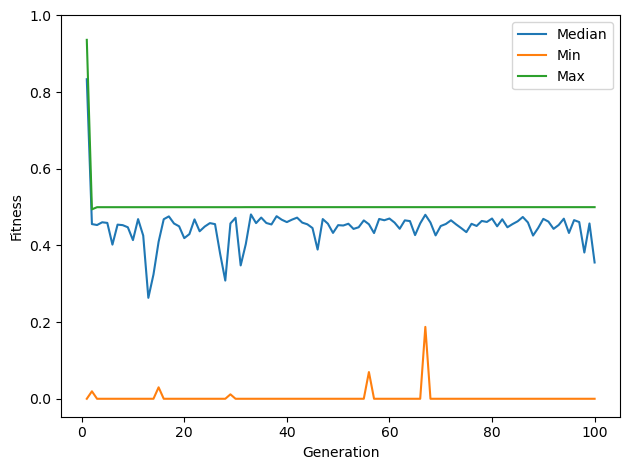

In [157]:
plt.figure()
x = range(1,maxgen+1)
plt.plot(x,np.median(arr_fit,axis=0),label='Median')
plt.plot(x,np.min(arr_fit,axis=0),label='Min')
plt.plot(x,np.max(arr_fit,axis=0),label='Max')
plt.ylim(top=1)
plt.legend()
plt.ylabel('Fitness')
plt.xlabel('Generation')
plt.tight_layout()


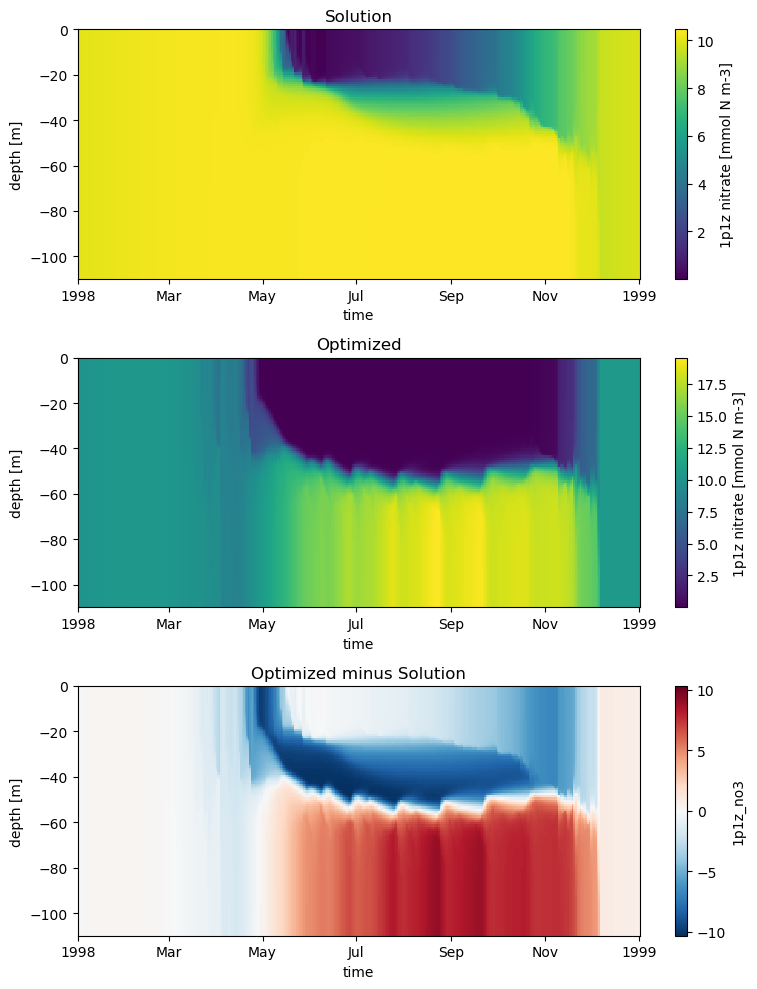

In [158]:
ds_best = xr.open_dataset('result_best.nc')

plt.figure(figsize=(8,10))

for i in range(len(tarvars)):
    plt.subplot(3,len(tarvars),i*3+1)
    ds_tar[tarvars[i]].plot(x='time')
    plt.title('Solution')
    plt.subplot(3,len(tarvars),i*3+2)
    ds_best[tarvars[i]].plot(x='time')
    plt.title('Optimized')
    plt.subplot(3,len(tarvars),i*3+3)
    (ds_best-ds_tar)[tarvars[i]].plot(x='time')
    plt.title('Optimized minus Solution')
plt.tight_layout()

### Standard output for setting the scene

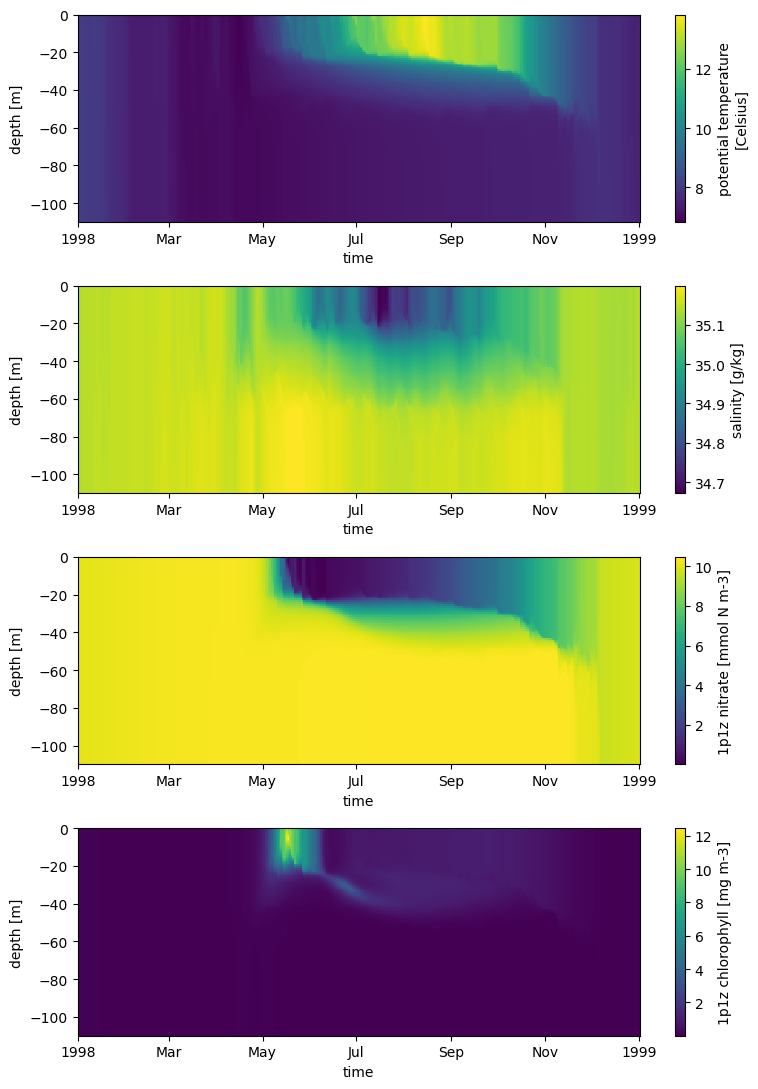

In [98]:
varlist = ['temp','salt',"1p1z_no3","1p1z_chl"]
ds = xr.open_dataset('result.nc')
plt.figure(figsize=(8,11))
for i in range(len(varlist)):
    plt.subplot(4,1,i+1)
    ds[varlist[i]].plot(x='time')
    plt.title(None)
plt.tight_layout()
plt.savefig('tsnc_control',dpi=300,bbox_inches='tight')

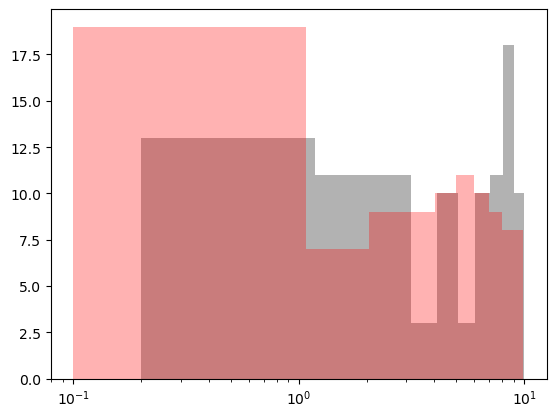

In [140]:
plt.figure()
plt.hist([round(np.random.uniform(0.1,10),1) for _ in range(100)],color='k',alpha=0.3)
plt.hist([np.random.choice(np.arange(0.1,10,0.1)) for _ in range(100)],color='r',alpha=0.3)
plt.xscale('log')

In [103]:
np.arange(0.1,10,0.1)

array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3,
       1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5, 2.6,
       2.7, 2.8, 2.9, 3. , 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9,
       4. , 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9, 5. , 5.1, 5.2,
       5.3, 5.4, 5.5, 5.6, 5.7, 5.8, 5.9, 6. , 6.1, 6.2, 6.3, 6.4, 6.5,
       6.6, 6.7, 6.8, 6.9, 7. , 7.1, 7.2, 7.3, 7.4, 7.5, 7.6, 7.7, 7.8,
       7.9, 8. , 8.1, 8.2, 8.3, 8.4, 8.5, 8.6, 8.7, 8.8, 8.9, 9. , 9.1,
       9.2, 9.3, 9.4, 9.5, 9.6, 9.7, 9.8, 9.9])